# Исследование банковских транзакций клиентов

**Цель исследования:**

Выявить особенности поведения клиентов на основе данных о транзакциях. Сегментировать клиентов и обнаружить аномалии или закономерности.

# Загрузка и предобработка

## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Данные взяты с сайта kaggle
[банковские транзакции](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation)

In [ ]:
# Импорты и настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка данных из файла
df_primary = pd.read_csv('/content/drive/MyDrive/Zerocode/PN14/bank_clients_transactions.csv')

In [ ]:
df_primary.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


## Приведение столбцов к стилю camel_case

In [ ]:
def to_camel_case(snake_case_string):
    """Преобразует строку в snake_case в camelCase."""
    components = snake_case_string.split('_')
    # Делаем первую букву каждого слова, кроме первого, заглавной
    return components[0] + ''.join(x.title() for x in components[1:])

def rename_columns_to_camel_case(df):
    """Переименовывает столбцы DataFrame в camelCase."""
    new_columns = {col: to_camel_case(col) for col in df.columns}
    return df.rename(columns=new_columns)

# Заменим пробелы и скобки в названиях столбцов на подчеркивания, чтобы их можно было правильно конвертировать в camelCase
df_primary.columns = df_primary.columns.str.replace(' ', '_')
df_primary.columns = df_primary.columns.str.replace(r'[\(\)]', '', regex=True)

# Применим функцию переименования
df_camel_case = rename_columns_to_camel_case(df_primary)

#Сделаем первую букву каждого столбца строчной в df_camel_case
df_camel_case.columns = [col[0].lower() + col[1:] if len(col) > 0 else col for col in df_camel_case.columns]

# Выведем DataFrame с новыми названиями столбцов
print(df_camel_case.columns)

Index(['transactionID', 'customerID', 'customerDOB', 'custGender',
       'custLocation', 'custAccountBalance', 'transactionDate',
       'transactionTime', 'transactionAmountInr'],
      dtype='object')


In [ ]:
# Создание переменной df для дальнейшей работы с данными
df = df_camel_case

## Приведение типов данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   transactionID         1048567 non-null  object 
 1   customerID            1048567 non-null  object 
 2   customerDOB           1045170 non-null  object 
 3   custGender            1047467 non-null  object 
 4   custLocation          1048416 non-null  object 
 5   custAccountBalance    1046198 non-null  float64
 6   transactionDate       1048567 non-null  object 
 7   transactionTime       1048567 non-null  int64  
 8   transactionAmountInr  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


В DataFrame содержится 1 048 567 записей. В некоторых столбцах присутствуют пропущенные значения (Non-Null Count меньше общего количества записей):

 - customerDOB: 1045170 непропущенных значений (есть пропуски)
 - custGender: 1047467 непропущенных значений (есть пропуски)
 - custLocation: 1048416 непропущенных значений (есть пропуски)
 - custAccountBalance: 1046198 непропущенных значений (есть пропуски)

Обработка пропусков и преобразование типов данных, особенно для столбцов с датами и временем (customerDOB, transactionDate, transactionTime), будут важными шагами перед анализом.

In [ ]:
# Преобразование дат
df['customerDOB'] = pd.to_datetime(df['customerDOB'], errors='coerce', dayfirst=True)
df['transactionDate'] = pd.to_datetime(df['transactionDate'], errors='coerce', dayfirst=True)

Обрабатываем столбец transactionTime, чтобы извлечь из него составляющие времени (часы, минуты, секунды) и преобразовать его в формат, удобный для анализа.

In [ ]:
# Обработка transactionTime
# Проверяем тип и диапазон значений transactionTime
print("\nПроверка transactionTime:")
# Округляем данные до целых чисел для вывода
time_description = df['transactionTime'].describe().round(0).astype(int)
print(time_description)

sample_time = df['transactionTime'].dropna().head(100).astype(str)



Проверка transactionTime:
count    1048567
mean      157088
std        51262
min            0
25%       124030
50%       164226
75%       200010
max       235959
Name: transactionTime, dtype: int64


Исходя из вывода ячейки, можно сделать следующие выводы о столбце transactionTime:

Значения варьируются от 0 до 235959.

Распределение: 25% значений меньше 124030, 50% (медиана) около 164226, а 75% меньше 200010. Это также согласуется с форматом ЧЧММСС, где большая часть транзакций происходит в дневное и вечернее время.

Таким образом, наиболее вероятный формат для transactionTime — это целое число, представляющее время в формате ЧЧММСС.

In [ ]:
# Предполагаем, что transactionTime в формате HHMMSS (int).
# Если другие форматы (секунды/миллисекунды от полуночи) обнаружатся
# в describe() или sample, логику нужно будет скорректировать.
try:
    # Попробуем парсить как HHMMSS
    df['hour'] = df['transactionTime'] // 10000
    df['minute'] = (df['transactionTime'] % 10000) // 100
    df['second'] = df['transactionTime'] % 100

    # Проверка на корректность значений (часы 0-23, минуты 0-59, секунды 0-59)
    invalid_time = df[(~df['hour'].between(0, 23)) |
                      (~df['minute'].between(0, 59)) |
                      (~df['second'].between(0, 59))]
    if not invalid_time.empty:
        print(f"\nОбнаружены некорректные компоненты времени в формате HHMMSS ({len(invalid_time)} строк).")
        # Можно удалить или обработать эти строки при необходимости
        # df.drop(invalid_time.index, inplace=True)
        # print(f"Удалено {len(invalid_time)} строк с некорректным временем.")
        # В данном случае оставим их и посмотрим на распределение minuteOfDay

    df['minuteOfDay'] = df['hour'] * 60 + df['minute']

except Exception as e:
    print(f"\nОшибка при попытке парсинга transactionTime как HHMMSS: {e}")
    print("Попробуем парсить как секунды или миллисекунды от полуночи...")
    # Если парсинг как HHMMSS не удался, попробуем другие юниты
    # Сначала секунды
    try:
        df['time_of_day'] = pd.to_timedelta(df['transactionTime'], unit='s', errors='coerce')
        df['minuteOfDay'] = (df['time_of_day'].dt.total_seconds() // 60).astype('Int64')
        df['hour'] = (df['time_of_day'].dt.total_seconds() // 3600).astype('Int64')
        df['minute'] = ((df['time_of_day'].dt.total_seconds() % 3600) // 60).astype('Int64')
        df['second'] = (df['time_of_day'].dt.total_seconds() % 60).astype('Int64')
        print("Успешно спарсили transactionTime как секунды от полуночи.")
    except Exception as e_s:
        print(f"Ошибка при парсинге как секунды: {e_s}")
        # Затем миллисекунды
        try:
            df['time_of_day'] = pd.to_timedelta(df['transactionTime'], unit='ms', errors='coerce')
            df['minuteOfDay'] = (df['time_of_day'].dt.total_seconds() // 60).astype('Int64')
            df['hour'] = (df['time_of_day'].dt.total_seconds() // 3600).astype('Int64')
            df['minute'] = ((df['time_of_day'].dt.total_seconds() % 3600) // 60).astype('Int64')
            df['second'] = (df['time_of_day'].dt.total_seconds() % 60).astype('Int64')
            print("Успешно спарсили transactionTime как миллисекунды от полуночи.")
        except Exception as e_ms:
            print(f"Ошибка при парсинге как миллисекунды: {e_ms}")
            print("Не удалось определить формат transactionTime.")
            # Оставляем колонки времени как NaN или заполняем нулями
            df['hour'] = np.nan
            df['minute'] = np.nan
            df['second'] = np.nan
            df['minuteOfDay'] = np.nan


# Числовые значения
df['custAccountBalance'] = pd.to_numeric(df['custAccountBalance'], errors='coerce')
df['transactionAmountInr'] = pd.to_numeric(df['transactionAmountInr'], errors='coerce')

In [ ]:
# вычитая 100 лет, чтобы получить корректный возраст.
mask = df["customerDOB"] > df["transactionDate"]
df.loc[mask, "customerDOB"] = df.loc[mask, "customerDOB"] - pd.DateOffset(years=100)

In [ ]:
df.head()

,transactionID,customerID,customerDOB,custGender,custLocation,custAccountBalance,transactionDate,transactionTime,transactionAmountInr,hour,minute,second,minuteOfDay
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.00,14,32,7,872
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.00,14,18,58,858
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.00,14,27,12,867
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.00,14,27,14,867
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.50,18,11,56,1091


In [ ]:
# Проверка типов данных
print("\nИнформация о типах данных в столбцах:")
df.info()


Информация о типах данных в столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   transactionID         1048567 non-null  object        
 1   customerID            1048567 non-null  object        
 2   customerDOB           1045170 non-null  datetime64[ns]
 3   custGender            1047467 non-null  object        
 4   custLocation          1048416 non-null  object        
 5   custAccountBalance    1046198 non-null  float64       
 6   transactionDate       1048567 non-null  datetime64[ns]
 7   transactionTime       1048567 non-null  int64         
 8   transactionAmountInr  1048567 non-null  float64       
 9   hour                  1048567 non-null  int64         
 10  minute                1048567 non-null  int64         
 11  second                1048567 non-null  int64         
 12  min

## Поиск дублей и пропусков в данных

In [ ]:
# Стандартизация колонок перед проверкой на неявные дубликаты
df['customerID'] = df['customerID'].astype(str).str.strip()
# customerDOB уже в datetime, сравнение будет корректным.
df['custLocation'] = df['custLocation'].astype(str).str.strip().str.title()


print("Дубликатов строк:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Удалим строки без ключевых полей
df.dropna(subset=['customerID', 'transactionDate', 'transactionAmountInr'], inplace=True)

Дубликатов строк: 0


In [ ]:
# Проверка числовых колонок
for col in ["custAccountBalance", "transactionAmountInr"]:
    print(f"\nПроверка {col}")
    print("Есть ли нечисловые значения:", pd.to_numeric(df[col], errors="coerce").isna().sum() - df[col].isna().sum())

# Проверка дат
for col in ["customerDOB", "transactionDate"]:
    parsed = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
    print(f"\n{col}: доля некорректных дат = {(parsed.isna().sum() / len(parsed)):.2%}")



Проверка custAccountBalance
Есть ли нечисловые значения: 0

Проверка transactionAmountInr
Есть ли нечисловые значения: 0

customerDOB: доля некорректных дат = 0.32%

transactionDate: доля некорректных дат = 0.00%


In [ ]:
# Проверка на неявные дубликаты по комбинации customerID, customerDOB, custLocation, исключая transactionAmountInr и transactionDate
columns_to_check = [col for col in df.columns if col not in ['transactionAmountInr', 'transactionDate', 'transactionTime', 'hour', 'minute', 'second', 'minute_of_day', 'day_of_week', 'day_of_week_name', 'customerAge', 'ageGroup']]
implicit_duplicates = df.duplicated(subset=columns_to_check, keep=False)

print("\nКоличество строк с неявными дубликатами (исключая данные транзакции):", implicit_duplicates.sum())

# Выведем примеры неявных дубликатов
if implicit_duplicates.sum() > 0:
    print("\nПримеры неявных дубликатов (исключая данные транзакции):")
    display(df[implicit_duplicates].sort_values(by=['customerID']).head())


Количество строк с неявными дубликатами (исключая данные транзакции): 0


In [ ]:
# Общая информация
print("\nПропущенные значения:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percentage})

# Округление процента
missing_info['Percentage'] = missing_info['Percentage'].round(2)

print(missing_info)


Пропущенные значения:
                      Count  Percentage
transactionID             0        0.00
customerID                0        0.00
customerDOB            3397        0.32
custGender             1100        0.10
custLocation              0        0.00
custAccountBalance     2369        0.23
transactionDate           0        0.00
transactionTime           0        0.00
transactionAmountInr      0        0.00
hour                      0        0.00
minute                    0        0.00
second                    0        0.00
minuteOfDay               0        0.00


Остались пропушенные значения в столбцах customerDOB (0,32%), custGender (0,10%), custAccountBalance. (0,23%).
Так как число пропусков не превышает 10% от общего количества строк, то строки с пропусками можно удалить.

In [ ]:
# Эта функция выводит информацию об изменении размера датафрейма после выполнения определенного шага обработки данных.
def report_size_change(before_len, after_len, step_name='step'):
    removed = before_len - after_len
    pct = removed / before_len if before_len else 0
    print(f"[{step_name}] rows before: {before_len}, after: {after_len}, removed: {removed} ({pct:.2%})")

In [ ]:
# Удаляем некорректные или отсутствующие даты
before_len_date_na = len(df)
df = df[df['transactionDate'].notna()].copy()
report_size_change(before_len_date_na, len(df), 'remove_transactionDate_na')

before_len_dob_na = len(df)
df = df[df['customerDOB'].notna()].copy()
report_size_change(before_len_dob_na, len(df), 'remove_customerDOB_na')


# Удаляем строки с пропущенными ключевыми значениями
before_len_gender_na = len(df)
df = df[df['custGender'].notna()].copy()
report_size_change(before_len_gender_na, len(df), 'remove_custGender_na')

before_len_location_na = len(df)
df = df[df['custLocation'].notna()].copy()
report_size_change(before_len_location_na, len(df), 'remove_custLocation_na')

before_len_balance_na = len(df)
df = df[df['custAccountBalance'].notna()].copy()
report_size_change(before_len_balance_na, len(df), 'remove_custAccountBalance_na')

# Удаляем нулевые и отрицательные значения
before_len_balance_zero = len(df)
df = df[df['custAccountBalance'] > 0].copy()
report_size_change(before_len_balance_zero, len(df), 'remove_zero_balance')

before_len_transaction_zero = len(df)
df = df[df['transactionAmountInr'] > 0].copy()
report_size_change(before_len_transaction_zero, len(df), 'remove_zero_transaction')


# Проверка на смещение после удаления пропусков (пример для пола и возрастной группы)
print("\nПроверка на смещение после удаления пропусков:")
print("Распределение по полу до удаления пропусков:")
# Выводим абсолютное количество
print(df_primary['CustGender'].value_counts(dropna=False))
print("\nРаспределение по полу после удаления пропусков:")
# Выводим абсолютное количество
print(df['custGender'].value_counts(dropna=False))

# Размер итогового датасета
print("\nРазмер очищенного набора данных:", df.shape)

[remove_transactionDate_na] rows before: 1048567, after: 1048567, removed: 0 (0.00%)
[remove_customerDOB_na] rows before: 1048567, after: 1045170, removed: 3397 (0.32%)
[remove_custGender_na] rows before: 1045170, after: 1044133, removed: 1037 (0.10%)
[remove_custLocation_na] rows before: 1044133, after: 1044133, removed: 0 (0.00%)
[remove_custAccountBalance_na] rows before: 1044133, after: 1041765, removed: 2368 (0.23%)
[remove_zero_balance] rows before: 1041765, after: 1039153, removed: 2612 (0.25%)
[remove_zero_transaction] rows before: 1039153, after: 1038337, removed: 816 (0.08%)

Проверка на смещение после удаления пропусков:
Распределение по полу до удаления пропусков:
CustGender
M      765530
F      281936
NaN      1100
T           1
Name: count, dtype: int64

Распределение по полу после удаления пропусков:
custGender
M    758517
F    279819
T         1
Name: count, dtype: int64

Размер очищенного набора данных: (1038337, 13)


Исходя из вывода ячейки, можно сделать следующие выводы:

* Были удалены строки с пропущенными значениями в столбцах `customerDOB`, `custGender`, `custAccountBalance`. Пропуски в `custLocation` исчезли после удаления строк с пропущенными значениями в ключевых столбцах.
* Были удалены строки с нулевыми или отрицательными значениями в столбцах `custAccountBalance` и `transactionAmountInr`.
* Было удалено 10230 строк (примерно 0.98% от исходного датасета 1048567 строк).
* Распределение по полу до и после удаления пропусков практически не изменилось, что указывает на отсутствие существенного смещения в данных по этому признаку.

Таким образом, после предобработки данных датасет стал более чистым и пригодным для дальнейшего анализа, при этом было удалено незначительное количество данных.

In [ ]:
# Проверка формата времени
df['hour'] = df['transactionTime'] // 10000
df['minute'] = (df['transactionTime'] % 10000) // 100
df['second'] = df['transactionTime'] % 100

print("\nНеверные компоненты времени:")
print("Часы:", df[~df['hour'].between(0, 23)].shape[0])
print("Минуты:", df[~df['minute'].between(0, 59)].shape[0])


Неверные компоненты времени:
Часы: 0
Минуты: 0


## Проверка качества данных

In [ ]:
# === 1. Числовые признаки ===
print("📊 Числовые признаки:")
display(df.select_dtypes(include=["number"]).describe().T)

# === 2. Категориальные признаки ===
print("\n🏷️ Категориальные признаки:")
display(df.select_dtypes(include=["category", "object"]).describe().T)

# === 3. Возраст клиентов ===
# Рассчитываем возраст клиента на момент каждой транзакции
df['customerAge'] = (df['transactionDate'] - df['customerDOB']).dt.days // 365

print("\n👤 Возраст клиентов:")
display(df["customerAge"].describe().to_frame().T)

# === 4. Проверка на аномалии возраста ===
anomalies = df[(df["customerAge"] < 14) | (df["customerAge"] > 100)]

print("\n⚠️ Проверка аномалий возраста:")
if anomalies.empty:
    print("✅ Аномалий нет: все возрасты в пределах 14–100 лет.")
else:
    print(f"❌ Найдено {len(anomalies)} аномальных записей.")
    display(anomalies[["customerID", "customerDOB", "customerAge", "transactionDate"]].head(10))

📊 Числовые признаки:


,count,mean,std,min,25%,50%,75%,max
custAccountBalance,1038337.00,115205.21,847420.30,0.01,4787.06,16857.89,57611.35,115035495.10
transactionTime,1038337.00,157174.47,51226.96,0.00,124104.00,164306.00,200029.00,235959.00
transactionAmountInr,1038337.00,1565.11,6561.91,0.01,161.00,458.00,1200.00,1560034.99
hour,1038337.00,15.42,5.12,0.00,12.00,16.00,20.00,23.00
minute,1038337.00,29.49,17.32,0.00,14.00,29.00,45.00,59.00
second,1038337.00,29.49,17.33,0.00,14.00,29.00,44.00,59.00
minuteOfDay,1038337.00,954.66,307.52,0.00,761.00,1003.00,1200.00,1439.00



🏷️ Категориальные признаки:


,count,unique,top,freq
transactionID,1038337,1038337,T1048567,1
customerID,1038337,877050,C6222360,6
custGender,1038337,3,M,758517
custLocation,1038337,9249,Mumbai,101688



👤 Возраст клиентов:


,count,mean,std,min,25%,50%,75%,max
customerAge,1038337.00,40.64,42.60,0.00,25.00,29.00,36.00,216.00



⚠️ Проверка аномалий возраста:
❌ Найдено 56072 аномальных записей.


,customerID,customerDOB,customerAge,transactionDate
16,C1376215,1800-01-01,216,2016-08-01
22,C7018081,1800-01-01,216,2016-08-03
28,C7935438,1800-01-01,216,2016-08-03
35,C1211387,1800-01-01,216,2016-08-03
151,C3334638,1800-01-01,216,2016-08-09
163,C7840374,1800-01-01,216,2016-08-09
182,C1638021,1800-01-01,216,2016-08-12
190,C1931276,1800-01-01,216,2016-08-08
193,C4325361,1800-01-01,216,2016-08-07
206,C7675278,1800-01-01,216,2016-08-07


In [ ]:
# Вывести топ-5 самых распространенных значений customerDOB
print("Топ-5 самых распространенных значений customerDOB:")
print(df['customerDOB'].value_counts().head())

Топ-5 самых распространенных значений customerDOB:
customerDOB
1800-01-01    55675
1989-01-01      809
1990-01-01      784
1991-08-06      698
1991-01-01      665
Name: count, dtype: int64


Исходя из проверки, можно сделать следующие выводы:

Столбцы custAccountBalance и transactionAmountInr имеют очень большой разброс и сильно скошены вправо (максимальные значения намного превышают среднее и медиану), что указывает на наличие выбросов или очень состоятельных клиентов/крупных транзакций.

Категориальные признаки:
transactionID уникален для каждой строки, как и ожидалось.
customerID имеет много повторяющихся значений, что говорит о том, что каждый клиент совершал несколько транзакций.
custGender показывает преобладание мужчин.
custLocation имеет большое количество уникальных значений.

Возраст клиентов:
Средний возраст составляет около 40 лет, но стандартное отклонение высокое.
Минимальный возраст клиента составляет 0 лет, а максимальный - 216 лет.
Обнаружено значительное количество записей с аномальным возрастом (младше 14 или старше 100 лет), многие из которых имеют дату рождения 1800-01-01 (ошибки ввода данных или значения по умолчанию). Эти аномалии требуют дальнейшей обработки (удаления или корректировки).

Обычно люди могут начать пользоваться банковскими услугами с 14-18 лет (в зависимости от законодательства и конкретных продуктов). Меньше - скорее всего, ошибка ввода данных или, возможно, транзакции, связанные с детскими счетами (но это требует дополнительной проверки и учета). Поэтому строки с возрастом клиента меньше 14 лет и старше 100 лет можно удалить

In [ ]:
# Удаляем строки с возрастом клиента младше 14 или старше 100 лет на момент транзакции
df = df[(df['customerAge'] >= 14) & (df['customerAge'] <= 100)].copy()

print("\nРазмер датасета после удаления строк с аномальными возрастами:", df.shape)


Размер датасета после удаления строк с аномальными возрастами: (982265, 14)


In [ ]:
df = df.reset_index(drop=True)  # drop=True удаляет старый индекс, если он не нужен

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982265 entries, 0 to 982264
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   transactionID         982265 non-null  object        
 1   customerID            982265 non-null  object        
 2   customerDOB           982265 non-null  datetime64[ns]
 3   custGender            982265 non-null  object        
 4   custLocation          982265 non-null  object        
 5   custAccountBalance    982265 non-null  float64       
 6   transactionDate       982265 non-null  datetime64[ns]
 7   transactionTime       982265 non-null  int64         
 8   transactionAmountInr  982265 non-null  float64       
 9   hour                  982265 non-null  int64         
 10  minute                982265 non-null  int64         
 11  second                982265 non-null  int64         
 12  minuteOfDay           982265 non-null  int64         
 13 

Данные подготовлены для исследования.

# Исследовательский анализ данных

In [ ]:
df

,transactionID,customerID,customerDOB,custGender,custLocation,custAccountBalance,transactionDate,transactionTime,transactionAmountInr,hour,minute,second,minuteOfDay,customerAge
0,T1,C5841053,1994-01-10,F,Jamshedpur,17819.05,2016-08-02,143207,25.00,14,32,7,872,22
1,T2,C2142763,1957-04-04,M,Jhajjar,2270.69,2016-08-02,141858,27999.00,14,18,58,858,59
2,T3,C4417068,1996-11-26,F,Mumbai,17874.44,2016-08-02,142712,459.00,14,27,12,867,19
3,T4,C5342380,1973-09-14,F,Mumbai,866503.21,2016-08-02,142714,2060.00,14,27,14,867,42
4,T5,C9031234,1988-03-24,F,Navi Mumbai,6714.43,2016-08-02,181156,1762.50,18,11,56,1091,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982260,T1048563,C8020229,1990-04-08,M,New Delhi,7635.19,2016-09-18,184824,799.00,18,48,24,1128,26
982261,T1048564,C6459278,1992-02-20,M,Nashik,27311.42,2016-09-18,183734,460.00,18,37,34,1117,24
982262,T1048565,C6412354,1989-05-18,M,Hyderabad,221757.06,2016-09-18,183313,770.00,18,33,13,1113,27
982263,T1048566,C6420483,1978-08-30,M,Visakhapatnam,10117.87,2016-09-18,184706,1000.00,18,47,6,1127,38


## Определение среднего количества транзакций на клиента

In [ ]:
# сколько уникальных клиентов после проверки качества данных?
unique_customers_primary = df_primary['CustomerID'].nunique()
unique_customers = df['customerID'].nunique()
print("Количество уникальных клиентов до очистки:", unique_customers_primary)
print("Количество уникальных клиентов после очистки:", unique_customers)

Количество уникальных клиентов до очистки: 884265
Количество уникальных клиентов после очистки: 836912


In [ ]:
# какое количество транзакций было совершено?
total_transactions_primary = len(df_primary)
total_transactions = len(df)
print("Общее количество транзакций до очистки:", total_transactions_primary)
print("Общее количество транзакций после очистки:", total_transactions)

Общее количество транзакций до очистки: 1048567
Общее количество транзакций после очистки: 982265


In [ ]:
# сколько в среднем транзакций приходится на одного клиента?
average_transactions_per_customer_primary = total_transactions_primary / unique_customers_primary
average_transactions_per_customer = total_transactions / unique_customers
print("Среднее количество транзакций на одного клиента до очистки:", round(average_transactions_per_customer_primary, 2))
print("Среднее количество транзакций на одного клиента после очистки:", round(average_transactions_per_customer, 2))

Среднее количество транзакций на одного клиента до очистки: 1.19
Среднее количество транзакций на одного клиента после очистки: 1.17


Таким образом, большинство клиентов выполнили по одной транзакции, а лишь небольшая доля клиентов совершила несколько операций.

## Изучение распределения и размаха величин Баланс счета и Сумма транзакции, проверка аномалий и выбросов

In [ ]:
#Настройка формата отображения чисел с плавающей запятой
pd.options.display.float_format = '{:.2f}'.format

print("Описание столбца custAccountBalance:")
print(df['custAccountBalance'].describe())

print("\nОписание столбца transactionAmountInr:")
print(df['transactionAmountInr'].describe())

Описание столбца custAccountBalance:
count      982265.00
mean       106243.13
std        818495.07
min             0.01
25%          4632.96
50%         16077.85
75%         53921.40
max     115035495.10
Name: custAccountBalance, dtype: float64

Описание столбца transactionAmountInr:
count    982265.00
mean       1451.78
std        6140.86
min           0.01
25%         152.00
50%         431.96
75%        1125.00
max     1560034.99
Name: transactionAmountInr, dtype: float64


**custAccountBalance (баланс на счёте клиента)**
* Количество записей: 982265 (без пропусков).
* Среднее: 106243.13.
* Медиана (50%): 16077.85 - значит распределение сильно скошено вправо (много клиентов с небольшим балансом, но есть редкие огромные значения).
* Стандартное отклонение: 818495.07 - очень большое, подтверждает наличие экстремальных значений.
* Мин: 0.01 - минимальный баланс близок к нулю.
* Макс: 115035495.10 - очень большие значения, что на 3 порядка выше медианы → аномалии или VIP-клиенты.

**transactionAmountInr (сумма транзакции, INR)**
* Количество записей: 982265 (без пропусков).
* Среднее: 1451.78.
* Медиана: 431.96 - снова распределение скошено вправо.
* Стандартное отклонение: 6140.86 - много разброса относительно среднего.
* Мин: 0.01 - транзакции минимального размера.
* Макс: 1560034.99 - редкие огромные транзакции, по сравнению с медианой (431.96) это в 3600 раз больше.

Из-за сильного смещения распределения баланса и суммы транзакций (наличие "длинных хвостов" с очень большими значениями), медиана (16078 INR для баланса и 432 INR для суммы транзакций) гораздо лучше характеризует типичного клиента или типичную транзакцию, чем среднее значение (106243 INR и 1452 INR соответственно). Среднее значение сильно искажается редкими, экстремально крупными значениями.

Для удобства визуализации для финансовых данных (балансы, транзакции) можно использовать 99-й перцентиль, как порог для выявления аномальных значений

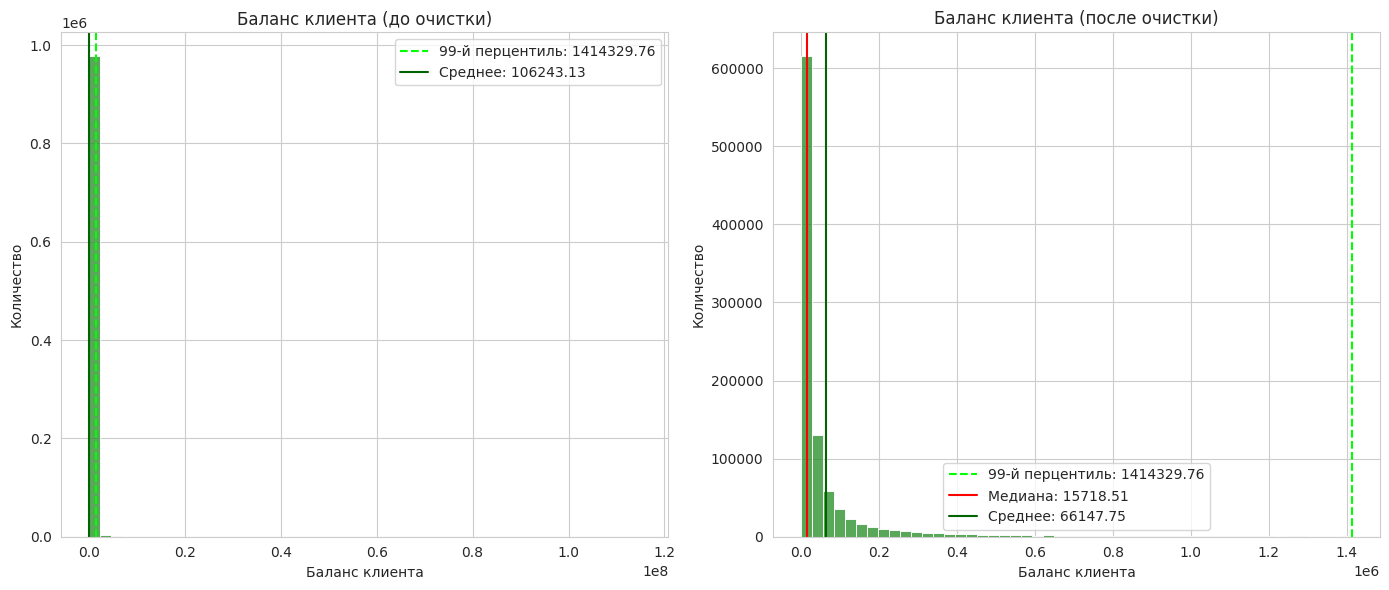

In [ ]:
# Рассчитываем 99-й перцентиль для баланса
balance_cap = df['custAccountBalance'].quantile(0.99)

# Фильтруем данные, чтобы удалить экстремальные значения для лучшей визуализации
# Используем 99-й перцентиль в качестве верхнего предела
df_filtered = df[df['custAccountBalance'] <= balance_cap].copy()

# Рассчитываем среднее значение баланса
mean_balance_original = df['custAccountBalance'].mean()
mean_balance_filtered = df_filtered['custAccountBalance'].mean()

# Создаем подграфики для гистограмм баланса: 1 ряд, 2 колонки
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма баланса клиента до очистки (первый ряд, первая колонка)
sns.histplot(df['custAccountBalance'], bins=50, ax=axes[0], color='forestgreen')
# Добавляем вертикальную линию на 99-м перцентиле
axes[0].axvline(balance_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {balance_cap:.2f}')
# Добавляем вертикальную линию на среднем значении
axes[0].axvline(mean_balance_original, color='darkgreen', linestyle='-', label=f'Среднее: {mean_balance_original:.2f}')
axes[0].set_title('Баланс клиента (до очистки)')
axes[0].set_xlabel('Баланс клиента')
axes[0].set_ylabel('Количество') # Изменяем подпись оси Y на русский
axes[0].legend() # Отображаем легенду

# Гистограмма баланса клиента после очистки (первый ряд, вторая колонка)
sns.histplot(df_filtered['custAccountBalance'], bins=50, ax=axes[1], color='forestgreen')
# Добавляем вертикальную линию на 99-м перцентиле
axes[1].axvline(balance_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {balance_cap:.2f}')
# Добавляем медиану на гистограмму баланса после очистки
median_balance_filtered = df_filtered['custAccountBalance'].median()
axes[1].axvline(median_balance_filtered, color='red', linestyle='-', label=f'Медиана: {median_balance_filtered:.2f}')
# Добавляем вертикальную линию на среднем значении
axes[1].axvline(mean_balance_filtered, color='darkgreen', linestyle='-', label=f'Среднее: {mean_balance_filtered:.2f}')
axes[1].set_title('Баланс клиента (после очистки)')
axes[1].set_xlabel('Баланс клиента')
axes[1].set_ylabel('Количество') # Изменяем подпись оси Y на русский
axes[1].legend() # Отображаем легенду


# Автоматически настраиваем расположение подграфиков
plt.tight_layout()
# Отображаем графики
plt.show()

Баланс клиента: распределение стало гораздо более наглядным. Видно, что основная масса клиентов имеет сравнительно небольшие балансы, сконцентрированные в левой части графика. Медиана (красная линия) показывает типичное значение баланса для большинства клиентов.

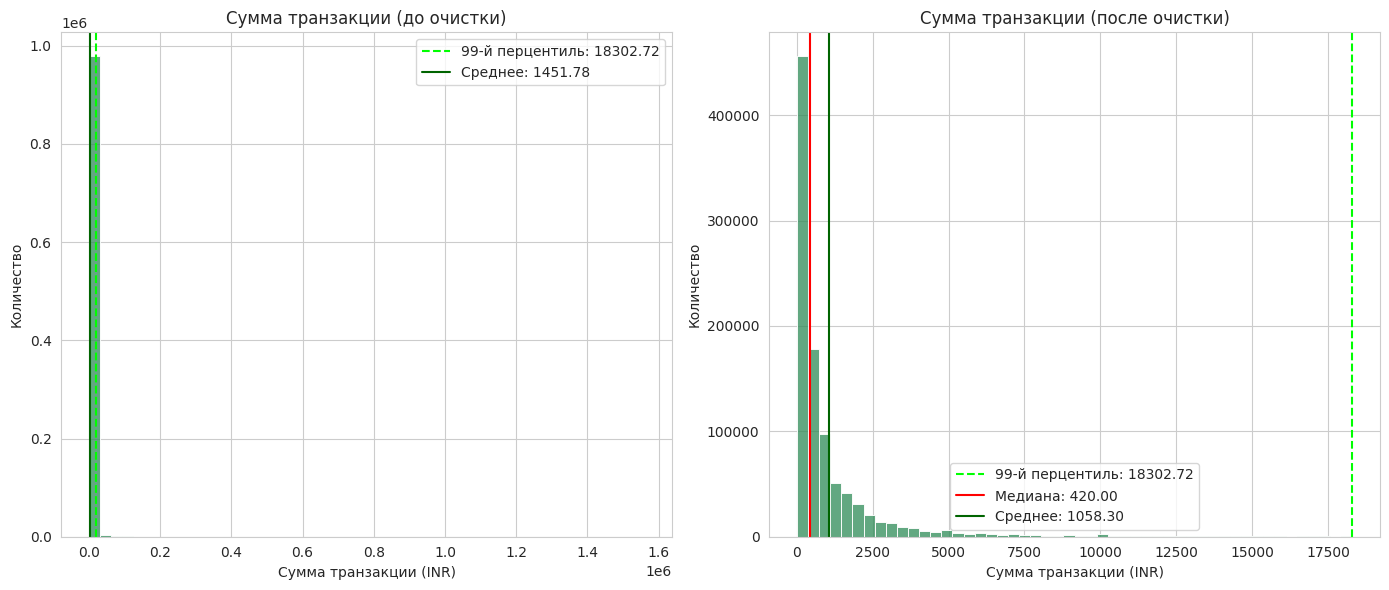

In [ ]:
# Рассчитываем 99-й перцентиль для суммы транзакций
txn_cap = df['transactionAmountInr'].quantile(0.99)

# Фильтруем данные, чтобы удалить экстремальные значения для лучшей визуализации
# Используем 99-й перцентиль в качестве верхнего предела
df_filtered = df[df['transactionAmountInr'] <= txn_cap].copy()

# Рассчитываем среднее значение суммы транзакций
mean_transaction_original = df['transactionAmountInr'].mean()
mean_transaction_filtered = df_filtered['transactionAmountInr'].mean()


# Создаем подграфики для гистограмм сумм транзакций: 1 ряд, 2 колонки
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма суммы транзакции до очистки (первый ряд, первая колонка)
sns.histplot(df['transactionAmountInr'], bins=50, ax=axes[0], color='seagreen')
# Добавляем вертикальную линию на 99-м перцентиле
axes[0].axvline(txn_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {txn_cap:.2f}')
# Добавляем вертикальную линию на среднем значении
axes[0].axvline(mean_transaction_original, color='darkgreen', linestyle='-', label=f'Среднее: {mean_transaction_original:.2f}')
axes[0].set_title('Сумма транзакции (до очистки)')
axes[0].set_xlabel('Сумма транзакции (INR)')
axes[0].set_ylabel('Количество') # Изменяем подпись оси Y на русский
axes[0].legend() # Отображаем легенду

# Гистограмма суммы транзакции после очистки (первый ряд, вторая колонка)
sns.histplot(df_filtered['transactionAmountInr'], bins=50, ax=axes[1], color='seagreen')
# Добавляем вертикальную линию на 99-м перцентиле
axes[1].axvline(txn_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {txn_cap:.2f}')
# Добавляем медиану на гистограмму суммы транзакций после очистки
median_transaction_filtered = df_filtered['transactionAmountInr'].median()
axes[1].axvline(median_transaction_filtered, color='red', linestyle='-', label=f'Медиана: {median_transaction_filtered:.2f}')
# Добавляем вертикальную линию на среднем значении
axes[1].axvline(mean_transaction_filtered, color='darkgreen', linestyle='-', label=f'Среднее: {mean_transaction_filtered:.2f}')
axes[1].set_title('Сумма транзакции (после очистки)')
axes[1].set_xlabel('Сумма транзакции (INR)')
axes[1].set_ylabel('Количество') # Изменяем подпись оси Y на русский
axes[1].legend() # Отображаем легенду

# Автоматически настраиваем расположение подграфиков
plt.tight_layout()
# Отображаем графики
plt.show()

Сумма транзакции: аналогично балансу, распределение сумм транзакций также показывает, что большинство транзакций имеют небольшую сумму. Медиана здесь также хорошо отражает типичную сумму транзакции.

Фильтрация по 99-му перцентилю позволила лучше рассмотреть основную часть данных, убрав влияние редких, экстремально больших значений, которые искажали бы вид графиков.

До: 982265 макс: 115035495.1
После: 972443 макс: 1414329.76


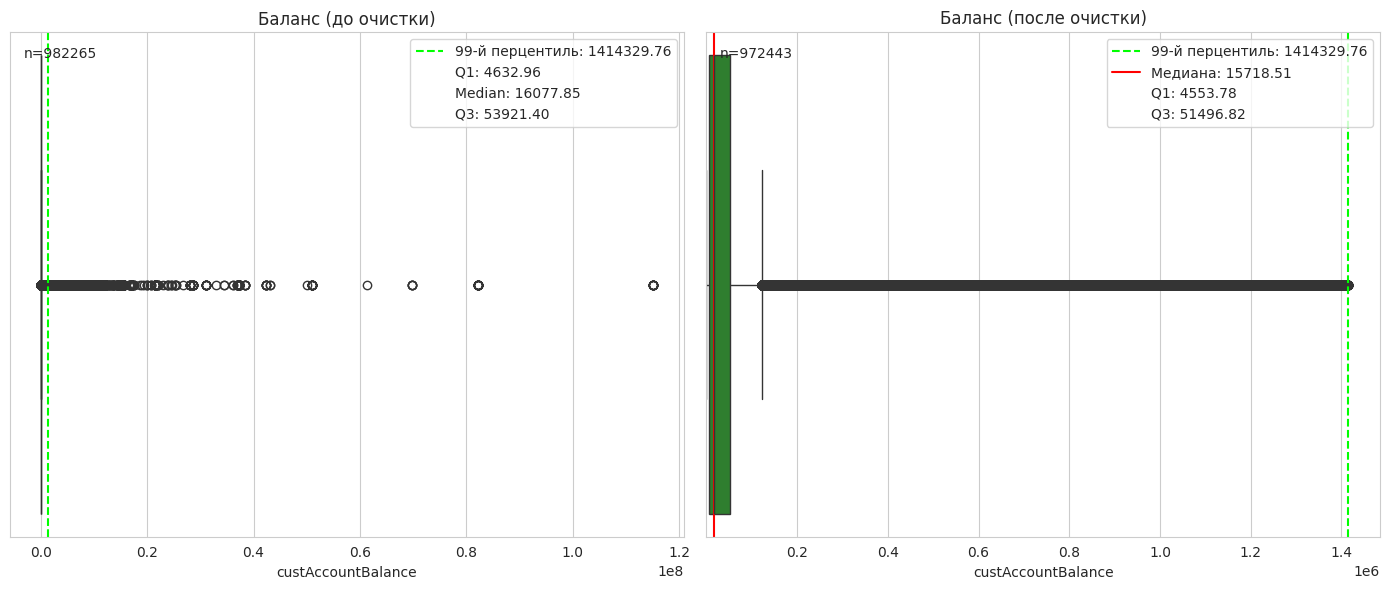

In [ ]:
balance_cap = df['custAccountBalance'].quantile(0.99)
df_filtered = df[df['custAccountBalance'] <= balance_cap].copy()

print("До:", len(df), "макс:", df['custAccountBalance'].max())
print("После:", len(df_filtered), "макс:", df_filtered['custAccountBalance'].max())

# Рассчитываем квартили для исходных и отфильтрованных данных
Q1_original = df['custAccountBalance'].quantile(0.25)
median_original = df['custAccountBalance'].median()
Q3_original = df['custAccountBalance'].quantile(0.75)

Q1_filtered = df_filtered['custAccountBalance'].quantile(0.25)
median_filtered = df_filtered['custAccountBalance'].median()
Q3_filtered = df_filtered['custAccountBalance'].quantile(0.75)


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

sns.boxplot(x=df['custAccountBalance'], ax=axes[0], color='forestgreen')
axes[0].axvline(balance_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {balance_cap:.2f}')
# Добавляем квартили в легенду
axes[0].plot([], [], ' ', label=f'Q1: {Q1_original:.2f}')
axes[0].plot([], [], ' ', label=f'Median: {median_original:.2f}')
axes[0].plot([], [], ' ', label=f'Q3: {Q3_original:.2f}')

axes[0].set_title('Баланс (до очистки)')
axes[0].legend(loc='upper right')
axes[0].text(0.02, 0.95, f'n={len(df)}', transform=axes[0].transAxes)

sns.boxplot(x=df_filtered['custAccountBalance'], ax=axes[1], color='forestgreen')
axes[1].axvline(balance_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {balance_cap:.2f}')
median_balance_filtered = df_filtered['custAccountBalance'].median()
axes[1].axvline(median_balance_filtered, color='red', linestyle='-', label=f'Медиана: {median_balance_filtered:.2f}')
# Добавляем квартили в легенду
axes[1].plot([], [], ' ', label=f'Q1: {Q1_filtered:.2f}')
axes[1].plot([], [], ' ', label=f'Q3: {Q3_filtered:.2f}')

axes[1].set_title('Баланс (после очистки)')
axes[1].legend(loc='upper right')
axes[1].text(0.02, 0.95, f'n={len(df_filtered)}', transform=axes[1].transAxes)

# Задать лимит по x на втором графике, чтобы видно было отличие:
axes[1].set_xlim(left=df_filtered['custAccountBalance'].min(), right=balance_cap * 1.05)

plt.tight_layout()
plt.show()

Основная часть данных по балансу счета и сумме транзакций сконцентрирована в левой части графика.

Медианы (красные линии) наглядно показывают типичные значения после удаления экстремальных выбросов.

Подавляющее большинство клиентов имеют низкий баланс – от 4554 до 51497 IRN, а также балансы до 1414330 IRN в 99% случаев.

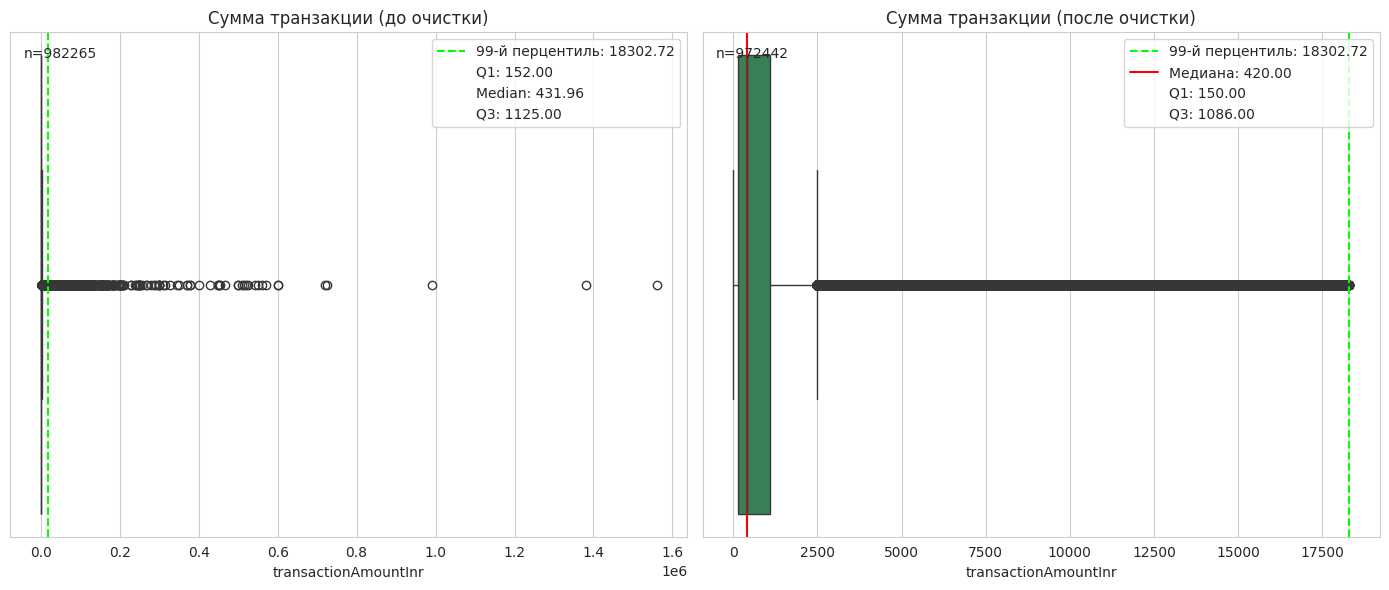

In [ ]:
# Рассчитываем 99-й перцентиль для суммы транзакций
txn_cap = df['transactionAmountInr'].quantile(0.99)

# Фильтруем данные, чтобы удалить экстремальные значения для лучшей визуализации
# Используем 99-й перцентиль в качестве верхнего предела
df_filtered = df[df['transactionAmountInr'] <= txn_cap].copy()

# Рассчитываем квартили для исходных и отфильтрованных данных
Q1_original = df['transactionAmountInr'].quantile(0.25)
median_original = df['transactionAmountInr'].median()
Q3_original = df['transactionAmountInr'].quantile(0.75)

Q1_filtered = df_filtered['transactionAmountInr'].quantile(0.25)
median_filtered = df_filtered['transactionAmountInr'].median() # Используем median_transaction_filtered из предыдущего кода, если он есть, или рассчитаем заново
Q3_filtered = df_filtered['transactionAmountInr'].quantile(0.75)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False) # sharey=False, так как масштабы могут сильно отличаться

# Боксплот для исходных данных
sns.boxplot(x=df['transactionAmountInr'], ax=axes[0], color='seagreen')
axes[0].axvline(txn_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {txn_cap:.2f}')
# Добавляем квартили в легенду
axes[0].plot([], [], ' ', label=f'Q1: {Q1_original:.2f}')
axes[0].plot([], [], ' ', label=f'Median: {median_original:.2f}')
axes[0].plot([], [], ' ', label=f'Q3: {Q3_original:.2f}')
axes[0].set_title('Сумма транзакции (до очистки)')
axes[0].set_xlabel('transactionAmountInr')
axes[0].legend(loc='upper right')
axes[0].text(0.02, 0.95, f'n={len(df)}', transform=axes[0].transAxes)


# Боксплот для данных, очищенных по 99-му перцентилю
sns.boxplot(x=df_filtered['transactionAmountInr'], ax=axes[1], color='seagreen')
axes[1].axvline(txn_cap, color='lime', linestyle='--', label=f'99-й перцентиль: {txn_cap:.2f}')
# Добавляем медиану на боксплот суммы транзакций после очистки
axes[1].axvline(median_filtered, color='red', linestyle='-', label=f'Медиана: {median_filtered:.2f}')
# Добавляем квартили в легенду
axes[1].plot([], [], ' ', label=f'Q1: {Q1_filtered:.2f}')
axes[1].plot([], [], ' ', label=f'Q3: {Q3_filtered:.2f}')
axes[1].set_title('Сумма транзакции (после очистки)')
axes[1].set_xlabel('transactionAmountInr')
axes[1].legend(loc='upper right')
axes[1].text(0.02, 0.95, f'n={len(df_filtered)}', transform=axes[1].transAxes)


plt.tight_layout()
plt.show()

Фильтрация по 99-му перцентилю позволила значительно сузить диапазон значений на графиках, делая основную часть данных более наглядной.

Большинство транзакций малы (от 150 до 1086 INR), а редкие крупные значения создают длинный хвост.

Так же для анализа используем логарифмированные данные.

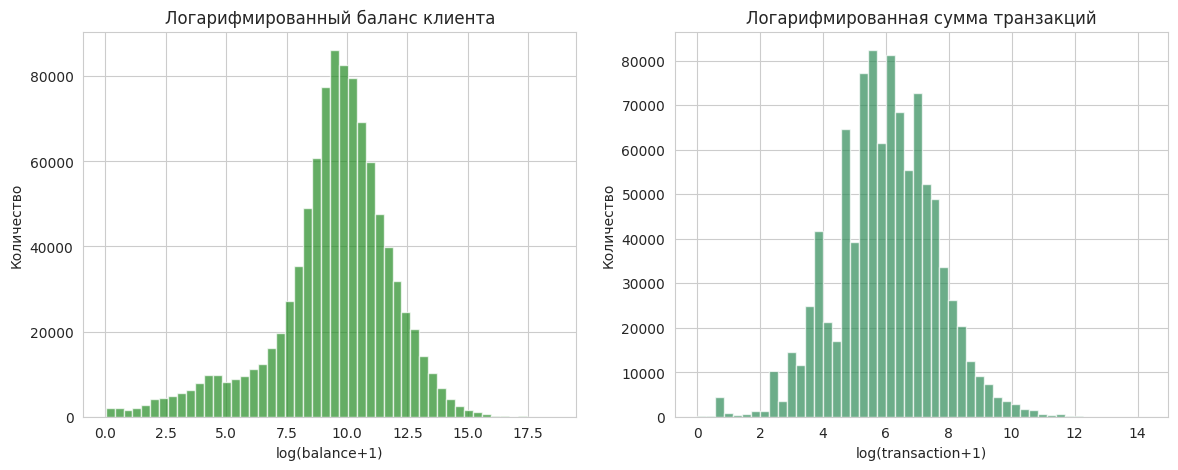

In [ ]:
# Логарифмирование
df['log_balance'] = np.log1p(df['custAccountBalance'])
df['log_transaction'] = np.log1p(df['transactionAmountInr'])

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Настройка палитры для единообразия
sns.set_palette("Greens")

axes[0].hist(df['log_balance'], bins=50, color='forestgreen', alpha=0.7) # Используем оттенок зеленого
axes[0].set_title('Логарифмированный баланс клиента')
axes[0].set_xlabel('log(balance+1)')
axes[0].set_ylabel('Количество')

axes[1].hist(df['log_transaction'], bins=50, color='seagreen', alpha=0.7) # Используем другой оттенок зеленого
axes[1].set_title('Логарифмированная сумма транзакций')
axes[1].set_xlabel('log(transaction+1)')
axes[1].set_ylabel('Количество')

plt.show()

Логарифмическое преобразование (с добавлением 1 для учета нулевых значений) сильно изменило распределение данных по балансу счета и сумме транзакций:
1. **Логарифмированный баланс клиента:** Распределение стало значительно более симметричным и напоминает нормальное распределение, хотя и с некоторым смещением. Это подтверждает, что большинство клиентов имеют низкие балансы, а логарифмирование помогает сжать "длинный хвост" с большими значениями.

 * Основной пик на графике — около log(balance+1) ≈ 9–10. В реальных значениях это ≈ 8100 - 22000 INR

Вывод: типичный баланс клиента находится в диапазоне от 8K до 22K INR, что хорошо совпадает с медианой (~16K INR).

2. **Логарифмированная сумма транзакций:** Распределение также стало более приближенным к нормальному, что указывает на то, что логарифмирование эффективно справилось с выбросами и сильной асимметрией исходных данных.

Основной пик на графике — около log(transaction+1) ≈ 5–7.

В реальных значениях это от 150 до 1 100 INR.

Вывод: типичная транзакция клиента находится в диапазоне от 150 до 1 100 INR, что также совпадает с медианной суммой (~432 INR).

## Анализ возраста клиентов

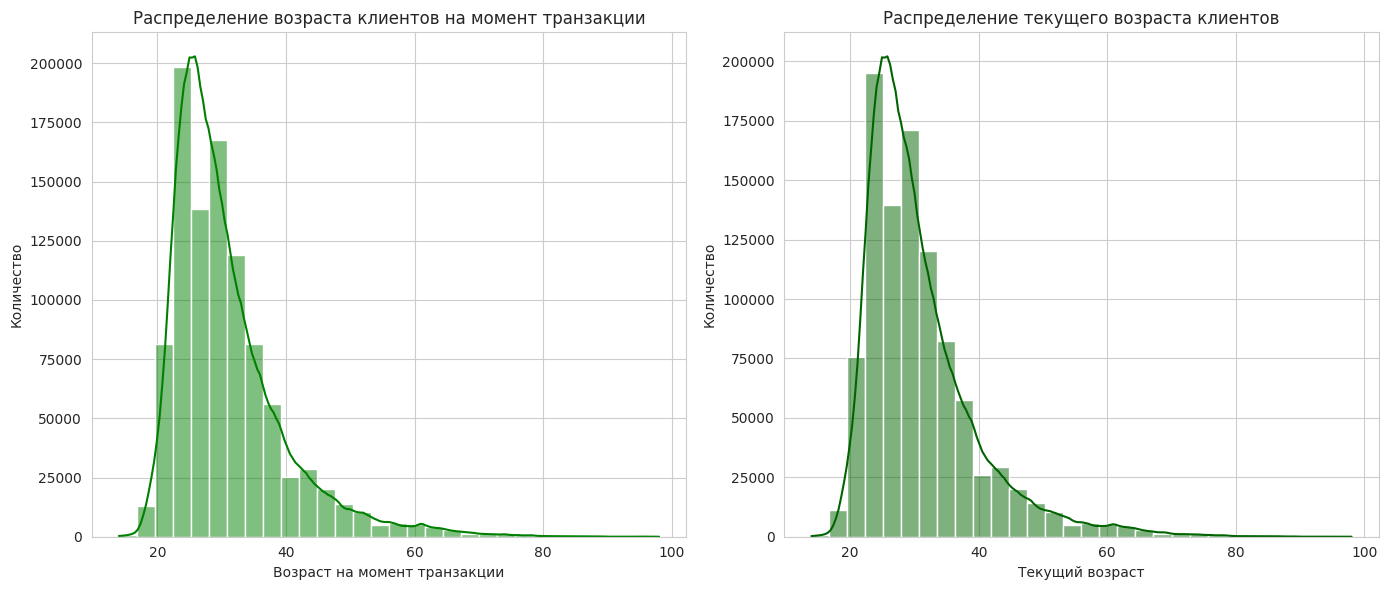

In [ ]:
# Анализ возраста клиентов

# Рассчитываем возраст клиента на момент каждой транзакции
df['customerAgeAtTransaction'] = (df['transactionDate'] - df['customerDOB']).dt.days // 365

# Рассчитываем текущий возраст клиента (на основе самой поздней даты транзакции в датасете)
latest_transaction_date = df['transactionDate'].max()
df['customerCurrentAge'] = (latest_transaction_date - df['customerDOB']).dt.days // 365


# Распределение возраста клиентов на момент транзакции
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['customerAgeAtTransaction'].dropna(), bins=30, kde=True, color='green')
plt.title('Распределение возраста клиентов на момент транзакции')
plt.xlabel('Возраст на момент транзакции')
plt.ylabel('Количество')

# Распределение текущего возраста клиентов
plt.subplot(1, 2, 2)
sns.histplot(df['customerCurrentAge'].dropna(), bins=30, kde=True, color='darkgreen')
plt.title('Распределение текущего возраста клиентов')
plt.xlabel('Текущий возраст')
plt.ylabel('Количество')


plt.tight_layout()
plt.show()

Графики выглядят одинаково, потому что в данном наборе данных дата всех транзакций находится в очень узком промежутке времени (2016 год). Поэтому возраст клиента на момент транзакции практически не отличается от его "текущего" возраста (на момент самой поздней транзакции в этом же датасете).

Основная масса клиентов находится в возрастном диапазоне примерно от 20 до 40 лет, с пиком около 25-30 лет. Распределение сдвинуто влево, что характерно для положительно скошенного распределения (больше молодых и среднего возраста, меньше пожилых).

## Изучение пола клиента


Распределение по полу:


,count
custGender,
M,710120
F,272145


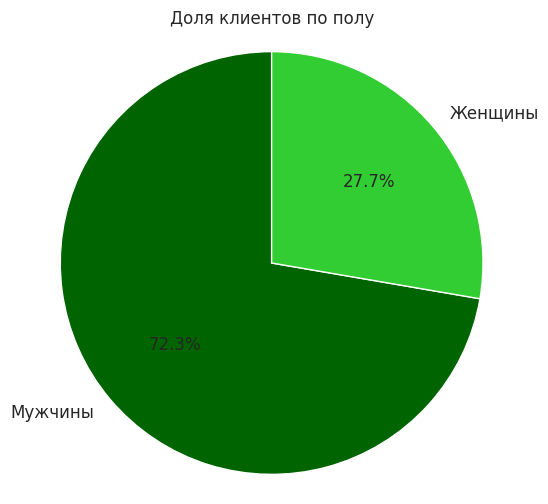

In [ ]:
gender_counts = df['custGender'].value_counts()

print("\nРаспределение по полу:")
display(gender_counts)

# Построить график доли клиентов по полу
plt.figure(figsize=(6, 6))
plt.pie(gender_counts.values,
        labels=['Мужчины', 'Женщины'], # Заменяем подписи на русские слова
        autopct='%1.1f%%',
        colors=['darkgreen', 'limegreen'], # Более контрастные зеленые оттенки
        startangle=90,
        textprops={'fontsize': 12})

plt.title('Доля клиентов по полу')
plt.axis('equal')
plt.show()

Круговая диаграмма наглядно демонстрирует преобладание мужчин: примерно три четверти клиентов – мужчины, четверть – женщины.

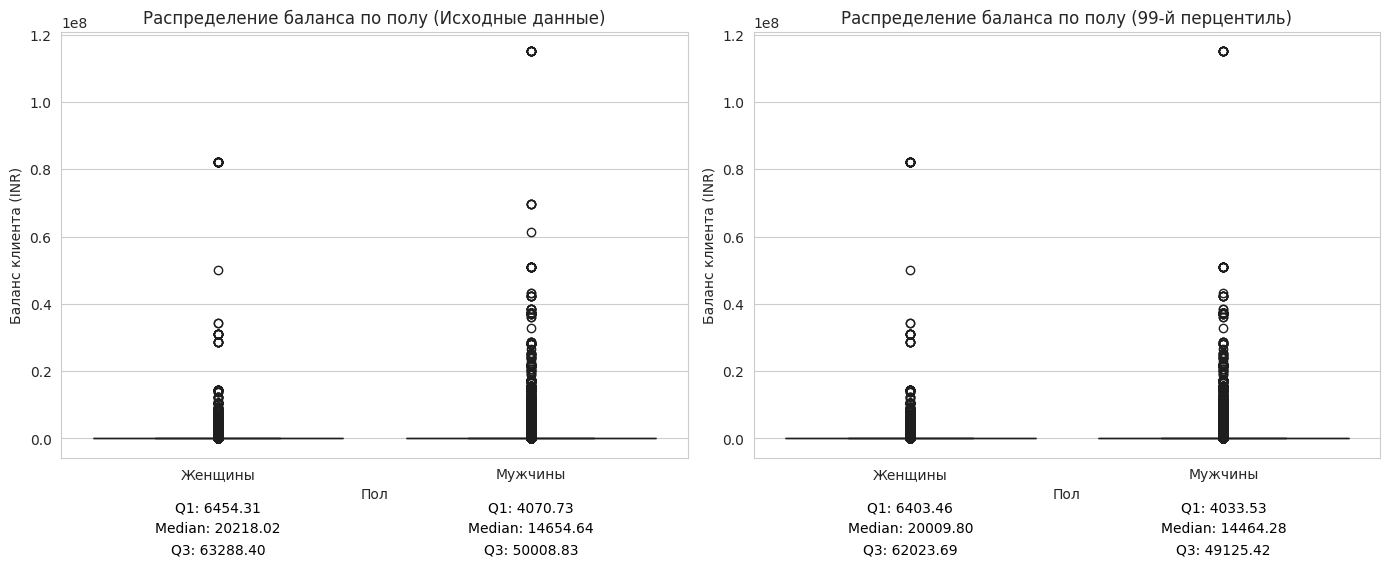


Среднее количество транзакций на клиента по полу:


custGender,F,M
0,1.05,1.12


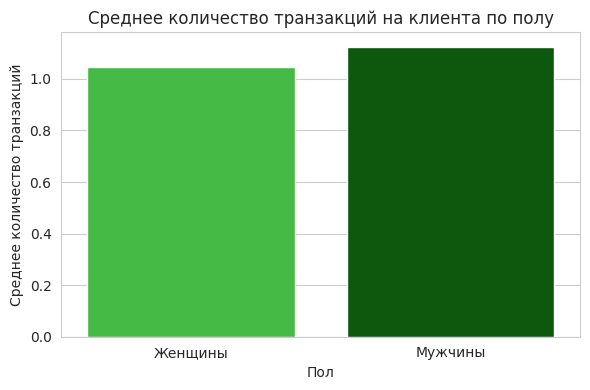

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False) # sharey=False, так как масштабы могут сильно отличаться

# Боксплот для исходных данных
sns.boxplot(x=df['custGender'].map({'M': 'Мужчины', 'F': 'Женщины'}), y='custAccountBalance', data=df, ax=axes[0], palette=['limegreen', 'darkgreen'])
axes[0].set_title('Распределение баланса по полу (Исходные данные)')
axes[0].set_xlabel('Пол')
axes[0].set_ylabel('Баланс клиента (INR)')

# Добавляем аннотации для исходных данных
for i, gender in enumerate(df['custGender'].unique()):
    subset_data = df[df['custGender'] == gender]['custAccountBalance']
    Q1 = subset_data.quantile(0.25)
    median = subset_data.median()
    Q3 = subset_data.quantile(0.75)

# Добавляем текст ниже оси X
    axes[0].text(i, axes[0].get_ylim()[0] - (axes[0].get_ylim()[1] - axes[0].get_ylim()[0]) * 0.1, f'Q1: {Q1:.2f}', color='black', fontsize=10, ha='center', va='top')
    axes[0].text(i, axes[0].get_ylim()[0] - (axes[0].get_ylim()[1] - axes[0].get_ylim()[0]) * 0.15, f'Median: {median:.2f}', color='black', fontsize=10, ha='center', va='top')
    axes[0].text(i, axes[0].get_ylim()[0] - (axes[0].get_ylim()[1] - axes[0].get_ylim()[0]) * 0.2, f'Q3: {Q3:.2f}', color='black', fontsize=10, ha='center', va='top')


# Боксплот для данных, очищенных по 99-му перцентилю
sns.boxplot(x=df_filtered['custGender'].map({'M': 'Мужчины', 'F': 'Женщины'}), y='custAccountBalance', data=df_filtered, ax=axes[1], palette=['limegreen', 'darkgreen'])
axes[1].set_title('Распределение баланса по полу (99-й перцентиль)')
axes[1].set_xlabel('Пол')
axes[1].set_ylabel('Баланс клиента (INR)')

# Добавляем аннотации для данных, очищенных по 99-й перцентиль
for i, gender in enumerate(df_filtered['custGender'].unique()):
    subset_data = df_filtered[df_filtered['custGender'] == gender]['custAccountBalance']
    Q1 = subset_data.quantile(0.25)
    median = subset_data.median()
    Q3 = subset_data.quantile(0.75)

    # Добавляем текст ниже оси X
    axes[1].text(i, axes[1].get_ylim()[0] - (axes[1].get_ylim()[1] - axes[1].get_ylim()[0]) * 0.1, f'Q1: {Q1:.2f}', color='black', fontsize=10, ha='center', va='top')
    axes[1].text(i, axes[1].get_ylim()[0] - (axes[1].get_ylim()[1] - axes[1].get_ylim()[0]) * 0.15, f'Median: {median:.2f}', color='black', fontsize=10, ha='center', va='top')
    axes[1].text(i, axes[1].get_ylim()[0] - (axes[1].get_ylim()[1] - axes[1].get_ylim()[0]) * 0.2, f'Q3: {Q3:.2f}', color='black', fontsize=10, ha='center', va='top')


plt.tight_layout()
plt.show()

# Находим есть ли разница в активности (количество транзакций на клиента) по полу
transactions_by_gender = df.groupby('custGender')['transactionID'].count()
unique_customers_by_gender = df.groupby('custGender')['customerID'].nunique()

average_transactions_per_customer_by_gender = transactions_by_gender / unique_customers_by_gender

print("\nСреднее количество транзакций на клиента по полу:")
display(average_transactions_per_customer_by_gender.to_frame().T)

# Визуализация среднего количества транзакций на клиента по полу
plt.figure(figsize=(6, 4))
sns.barplot(x=average_transactions_per_customer_by_gender.index.map({'M': 'Мужчины', 'F': 'Женщины'}), y=average_transactions_per_customer_by_gender.values, palette=['limegreen', 'darkgreen'], hue=average_transactions_per_customer_by_gender.index.map({'M': 'Мужчины', 'F': 'Женщины'}), legend=False)
plt.title('Среднее количество транзакций на клиента по полу')
plt.xlabel('Пол')
plt.ylabel('Среднее количество транзакций')
plt.tight_layout()
plt.show()

*  Медиана баланса у женщин немного выше, чем у мужчин, что указывает на то, что, в среднем, баланс у женщин выше.
*  Квартили показывают, что у женщин, как правило, большая часть балансов приходится на более высокие значения, чем у мужчин.
* По количеству транзакции большую активность проявляли мужчины.

## Изучение места жительства клиентов

Количество уникальных местоположений: 8144

Топ 10 самых частых местоположений:


,count
custLocation,
Mumbai,97409
Bangalore,77543
New Delhi,76072
Gurgaon,70372
Delhi,67042
Noida,31627
Chennai,27391
Pune,24449
Hyderabad,21755


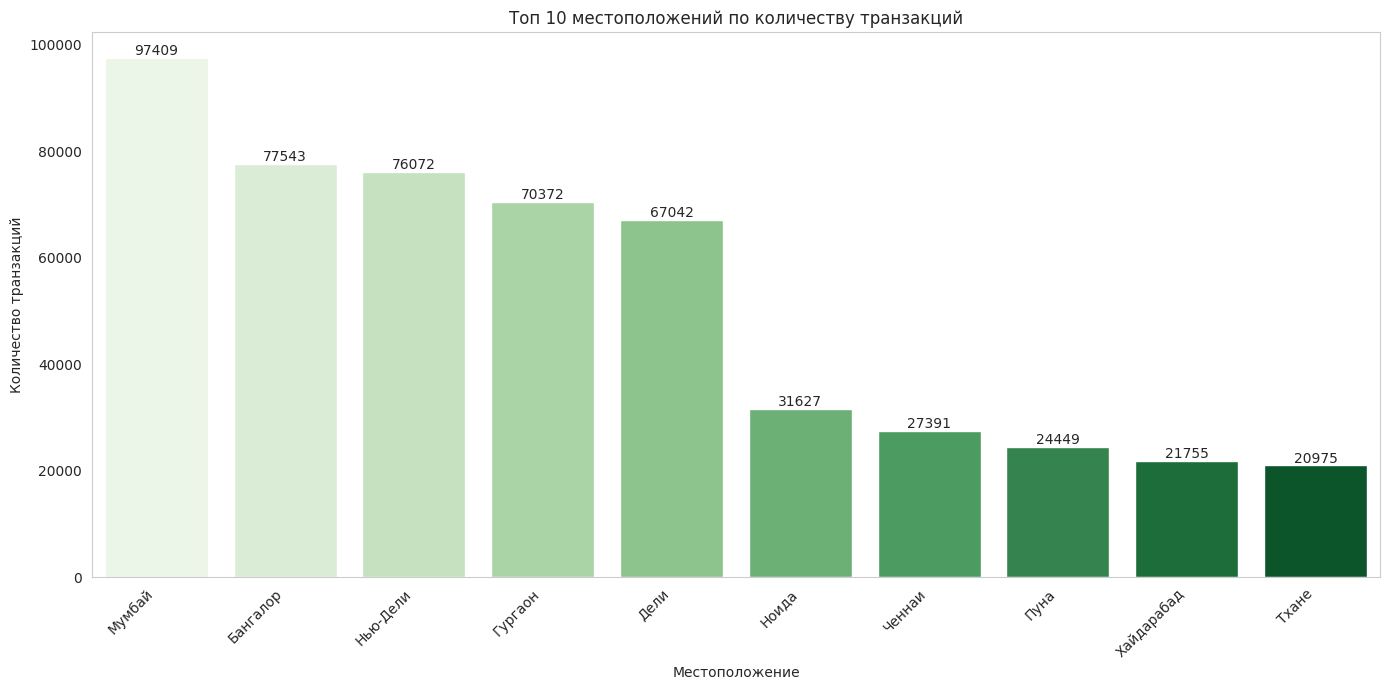

In [ ]:
# Посмотрим на количество уникальных локаций
unique_locations = df['custLocation'].nunique()
print(f"Количество уникальных местоположений: {unique_locations}")

# Выведем топ 10 самых частых местоположений
top_10_locations = df['custLocation'].value_counts().head(10)
print("\nТоп 10 самых частых местоположений:")
display(top_10_locations)

# Создадим словарь для перевода названий городов
city_translation = {
    'Mumbai': 'Мумбай',
    'Bangalore': 'Бангалор',
    'New Delhi': 'Нью-Дели',
    'Gurgaon': 'Гургаон',
    'Delhi': 'Дели',
    'Noida': 'Ноида',
    'Chennai': 'Ченнаи',
    'Pune': 'Пуна',
    'Hyderabad': 'Хайдарабад',
    'Thane': 'Тхане'
}

# Визуализируем топ 10 местоположений по количеству транзакций
plt.figure(figsize=(14, 7)) # Увеличиваем размер графика
ax = sns.barplot(x=top_10_locations.index.map(city_translation), y=top_10_locations.values, palette='Greens', hue=top_10_locations.index.map(city_translation), legend=False)
plt.title('Топ 10 местоположений по количеству транзакций')
plt.xlabel('Местоположение')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем подписи с количеством транзакций над столбиками
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Убираем линии сетки
ax.grid(False)


plt.show()

Всего клиенты представлены в 8144 разных населенных пунктах. Лидируют крупные города Индии, с многомилионным населением (в частности, Мумбай, Бангалор, Нью-Дели и др.), что отражает концентрацию клиентской базы в густонаселенных регионах.

## Динамика транзакций по дате (в кол-ве TransactionID)

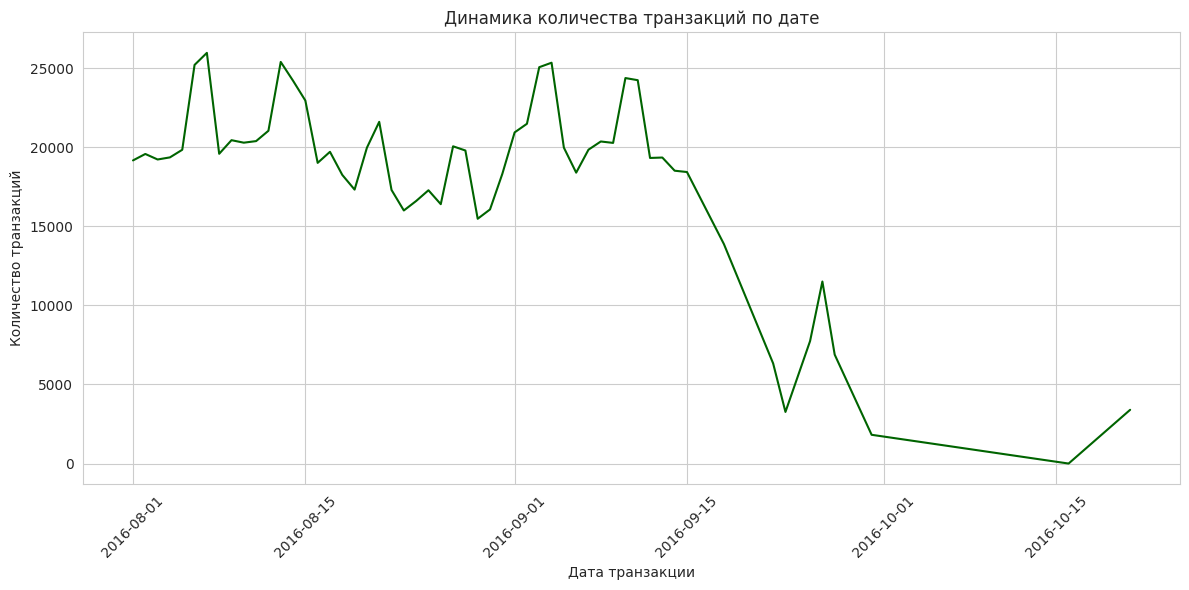

In [ ]:
# Группируем данные по дате транзакции и считаем количество уникальных transactionID
transactions_by_date_count = df.groupby('transactionDate')['transactionID'].nunique().reset_index()

# Сортируем по дате для корректного отображения на графике
transactions_by_date_count = transactions_by_date_count.sort_values('transactionDate')

# Визуализируем динамику количества транзакций по дате
plt.figure(figsize=(12, 6))
sns.lineplot(data=transactions_by_date_count, x='transactionDate', y='transactionID', color='darkgreen', linewidth=1.5)
plt.title('Динамика количества транзакций по дате')
plt.xlabel('Дата транзакции')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

В период с сентября по ноябрь наблюдается резкое снижение количества транзакций. Это может быть вызвано разными факторами:
  *  Сезонность (например, праздники, отпуска).
  *  Изменение в бизнес-процессах банка.
  *  Внешние факторы (например, экономические изменения, нововведения конкурентов).
  *  Технические проблемы.

## Определение самой платежеспособной группы по возрасту


Анализ платежеспособности по возрастным группам:


,ageGroup,averageAccountBalance,averageTransactionAmount,numberOfCustomers
5,65+,563877.22,3600.65,7803
4,55-64,512377.94,3336.23,17410
3,45-54,311243.22,2855.81,47299
2,35-44,179806.19,2086.81,159543
1,25-34,74346.79,1282.20,489155
0,<24,32453.68,830.61,202573


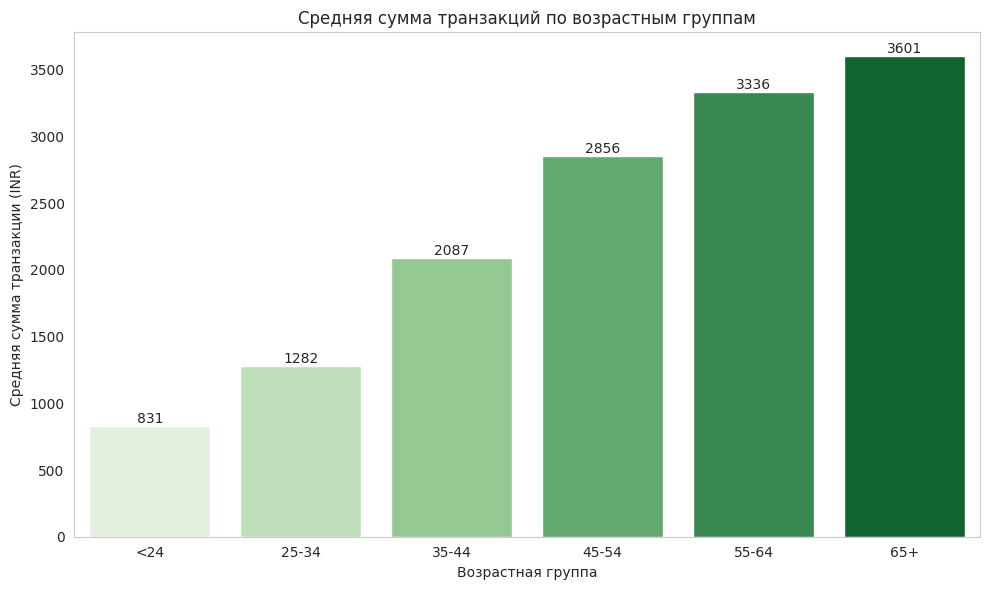

In [ ]:
# разбить клиентов на корзины по возрасту и определить самую платежеспособную группу

# Рассчитываем возраст клиента на момент последней транзакции
latest_transaction_date = df['transactionDate'].max()
df['customerAge'] = (latest_transaction_date - df['customerDOB']).dt.days // 365

# Создаем возрастные корзины
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['<24', '25-34', '35-44', '45-54', '55-64', '65+']
df['ageGroup'] = pd.cut(df['customerAge'], bins=age_bins, labels=age_labels, right=False)

# Анализируем платежеспособность по возрастным группам (например, средний баланс или средняя сумма транзакции)
# Сгруппируем по возрастным группам и рассчитаем средний баланс и среднюю сумму транзакций
age_group_analysis = df.groupby('ageGroup', observed=False).agg(
    averageAccountBalance=('custAccountBalance', 'mean'),
    averageTransactionAmount=('transactionAmountInr', 'mean'),
    numberOfCustomers=('customerID', 'nunique')
).reset_index()

print("\nАнализ платежеспособности по возрастным группам:")
display(age_group_analysis.sort_values('averageTransactionAmount', ascending=False))

# Визуализируем среднюю сумму транзакций по возрастным группам
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ageGroup', y='averageTransactionAmount', data=age_group_analysis, palette='Greens', hue='ageGroup', legend=False)
plt.title('Средняя сумма транзакций по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Средняя сумма транзакции (INR)')
plt.tight_layout()

# Добавляем подписи со значениями над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Убираем линии сетки
ax.grid(False)

plt.show()

Видно, что с увеличением возраста средняя сумма транзакций растёт:
  - Меньше всего тратят клиенты младше 24 лет (около 800 INR).
  - Самая высокая средняя сумма у клиентов старше 65 лет (около 3600 INR).

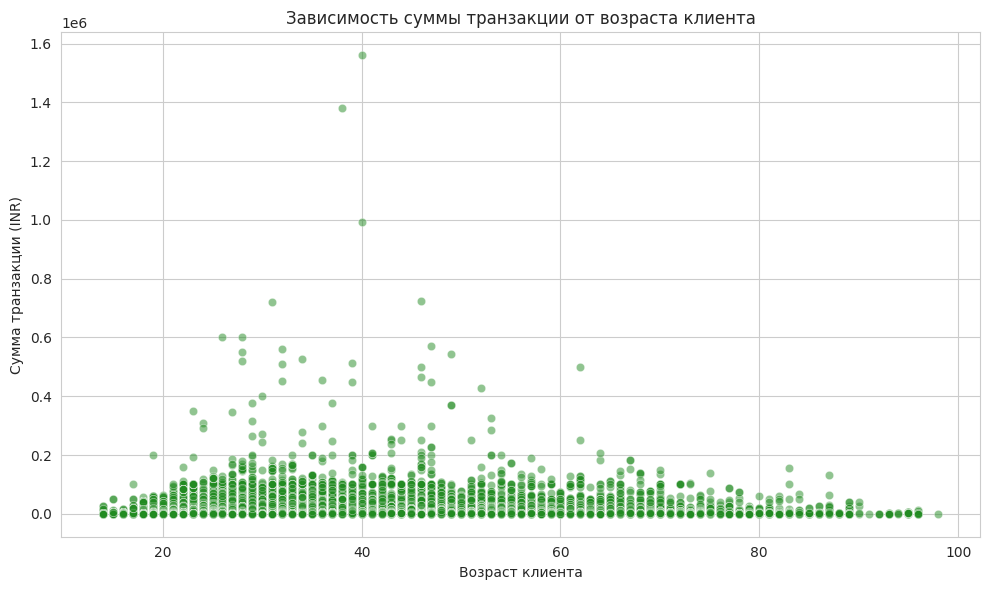

In [ ]:
# Исследование зависимости между возрастом клиента и суммой транзакции

# Рассчитываем возраст клиента на момент последней транзакции
latest_transaction_date = df['transactionDate'].max()
df['customerAge'] = (latest_transaction_date - df['customerDOB']).dt.days // 365

# Создаем возрастные корзины
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['<24', '25-34', '35-44', '45-54', '55-64', '65+']
df['ageGroup'] = pd.cut(df['customerAge'], bins=age_bins, labels=age_labels, right=False)

# Анализируем платежеспособность по возрастным группам (например, средний баланс или средняя сумма транзакции)
# Сгруппируем по возрастным группам и рассчитаем средний баланс и среднюю сумму транзакций
age_group_analysis = df.groupby('ageGroup', observed=False).agg(
    averageAccountBalance=('custAccountBalance', 'mean'),
    averageTransactionAmount=('transactionAmountInr', 'mean'),
    numberOfCustomers=('customerID', 'nunique')
).reset_index()


# Построим scatter plot для визуализации зависимости
plt.figure(figsize=(10, 6))
sns.scatterplot(x='customerAge', y='transactionAmountInr', data=df, alpha=0.5, color='forestgreen')
plt.title('Зависимость суммы транзакции от возраста клиента')
plt.xlabel('Возраст клиента')
plt.ylabel('Сумма транзакции (INR)')
plt.tight_layout()
plt.show()


- Каждая точка на графике представляет собой одного клиента, где координата по оси X – его возраст, а по оси Y – общая сумма его транзакций.
- Визуально точки распределены в основном в нижней части графика, что указывает на то, что у большинства клиентов сумма транзакций не очень велика.
- Есть несколько точек, значительно выделяющихся, с высокими значениями суммы транзакций (более 0,6 млн INR), но они скорее исключение, чем правило.
- Визуально не наблюдается явной зависимости между возрастом и суммой транзакций: точки распределены довольно хаотично.

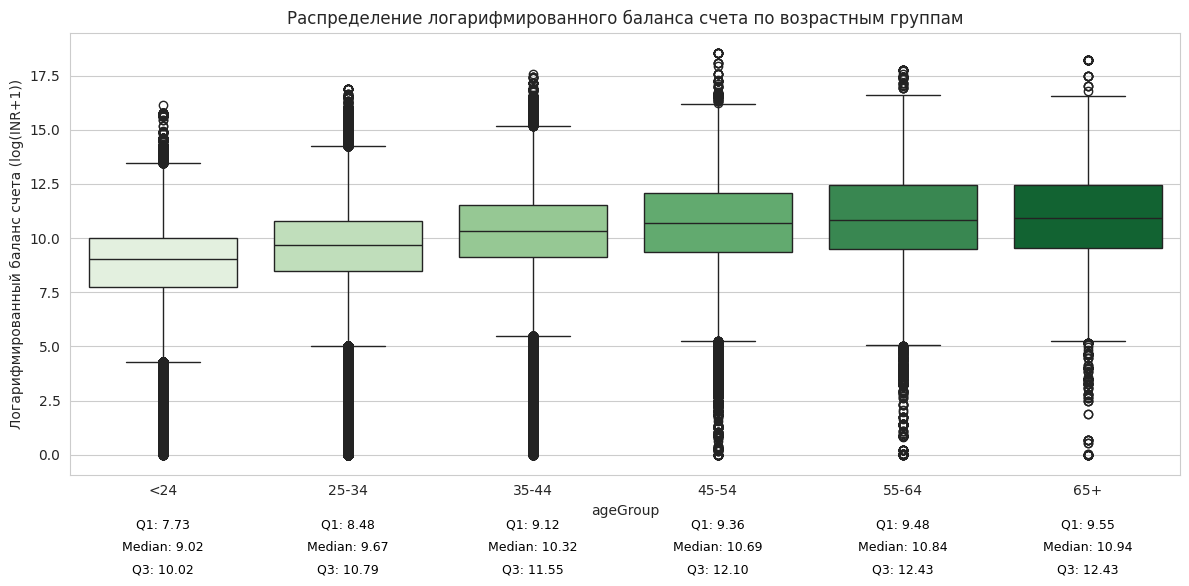

In [ ]:
# Для лучшей визуализации из-за выбросов, используем логарифмированный баланс

# Логарифмирование (создаем столбец log_balance, если его нет)
if 'log_balance' not in df.columns:
    df['log_balance'] = np.log1p(df['custAccountBalance'])

plt.figure(figsize=(12, 6))
ax2 = sns.boxplot(x='ageGroup', y='log_balance', data=df, palette='Greens', hue='ageGroup', legend=False)
plt.title('Распределение логарифмированного баланса счета по возрастным группам')
plt.ylabel('Логарифмированный баланс счета (log(INR+1))')

# Добавляем аннотации для второго графика
for i, group in enumerate(df['ageGroup'].cat.categories):
    subset_data = df[df['ageGroup'] == group]['log_balance']
    Q1 = subset_data.quantile(0.25)
    median = subset_data.median()
    Q3 = subset_data.quantile(0.75)

    # Добавляем текст ниже оси X
    ax2.text(i, ax2.get_ylim()[0] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.1, f'Q1: {Q1:.2f}', color='black', fontsize=9, ha='center', va='top')
    ax2.text(i, ax2.get_ylim()[0] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.15, f'Median: {median:.2f}', color='black', fontsize=9, ha='center', va='top')
    ax2.text(i, ax2.get_ylim()[0] - (ax2.get_ylim()[1] - ax2.get_ylim()[0]) * 0.2, f'Q3: {Q3:.2f}', color='black', fontsize=9, ha='center', va='top')


plt.tight_layout()
plt.show()

С использованием логарифмированного баланса видно, что с ростом возраста медианный баланс и разброс сумм баланса увеличивается.

Молодые клиенты более «однородны», у них относительно небольшие балансы.

С возрастом клиенты аккумулируют больше средств, и различия между ними становятся сильнее.

Самые «богатые сегменты» — это 45+ лет, особенно 55–64 и 65+.

## Распределение транзакций по локациям

Топ 10 местоположений по количеству транзакций:


,count
custLocation,
Mumbai,97409
Bangalore,77543
New Delhi,76072
Gurgaon,70372
Delhi,67042
Noida,31627
Chennai,27391
Pune,24449
Hyderabad,21755


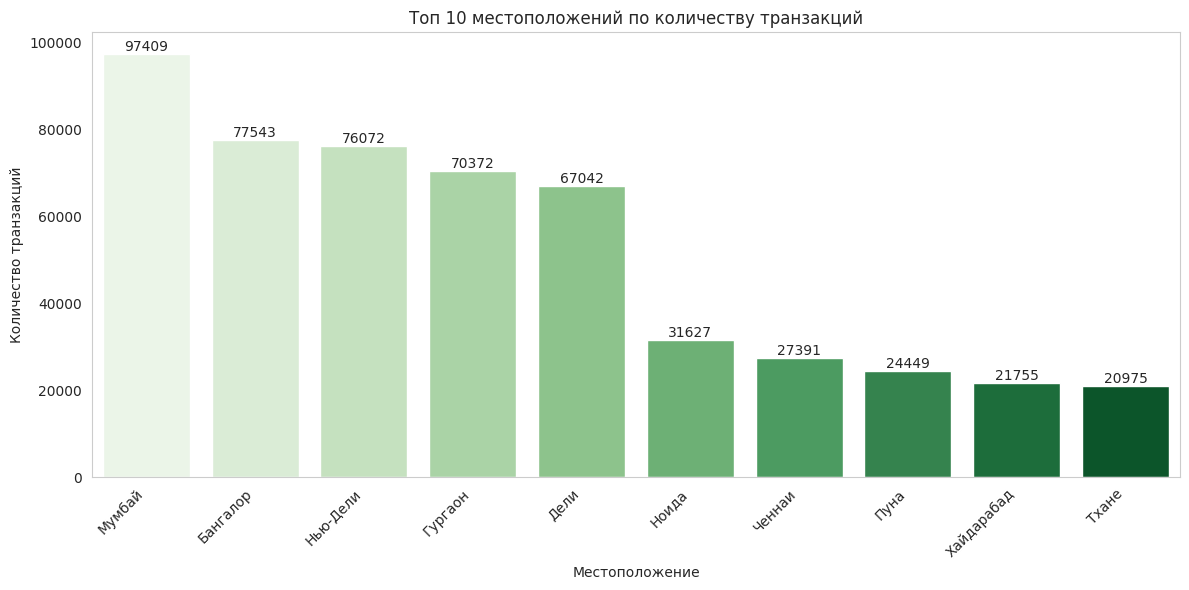


Топ 10 местоположений по сумме транзакций:


,transactionAmountInr
custLocation,
Mumbai,161306822.15
New Delhi,130311611.94
Bangalore,105139720.89
Gurgaon,101034422.11
Delhi,92699939.84
Noida,41880204.27
Kolkata,40656866.62
Chennai,38106020.94
Pune,34924858.67


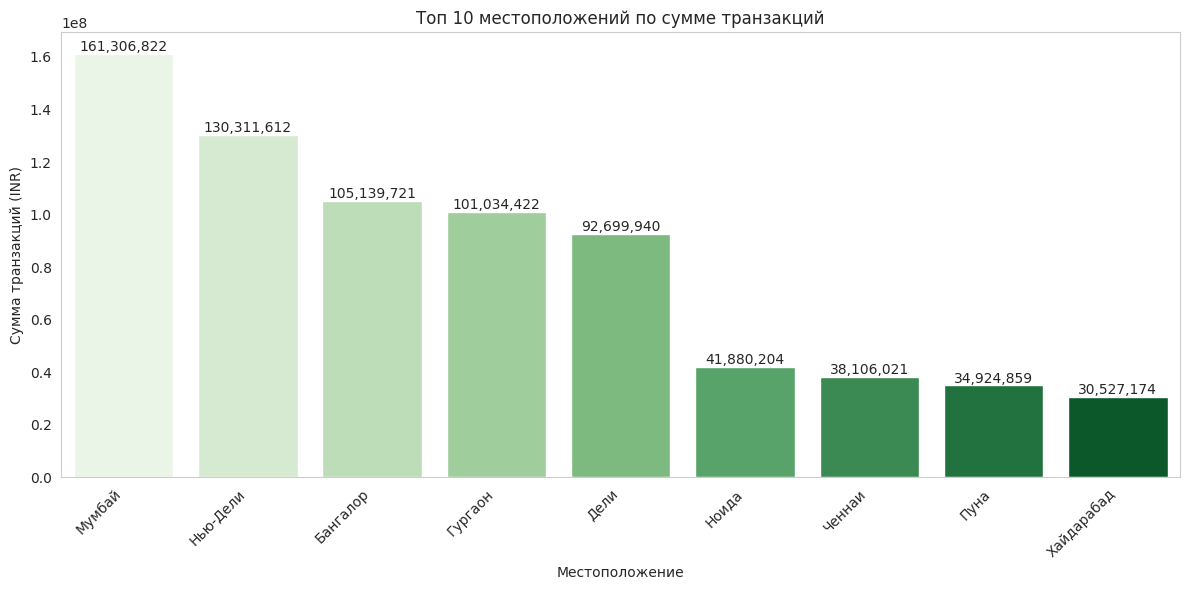

In [ ]:
# Топ 10 местоположений по количеству транзакций
top_10_locations_count = df['custLocation'].value_counts().head(10)
print("Топ 10 местоположений по количеству транзакций:")
display(top_10_locations_count)

# Создадим словарь для перевода названий городов
city_translation = {
    'Mumbai': 'Мумбай',
    'Bangalore': 'Бангалор',
    'New Delhi': 'Нью-Дели',
    'Gurgaon': 'Гургаон',
    'Delhi': 'Дели',
    'Noida': 'Ноида',
    'Chennai': 'Ченнаи',
    'Pune': 'Пуна',
    'Hyderabad': 'Хайдарабад',
    'Thane': 'Тхане'
}

# Визуализируем топ 10 местоположений по количеству транзакций
plt.figure(figsize=(12, 6))
# Используем переведенные названия городов для меток на графике
ax_count = sns.barplot(x=top_10_locations_count.index.map(city_translation), y=top_10_locations_count.values, palette='Greens', hue=top_10_locations_count.index.map(city_translation), legend=False)
plt.title('Топ 10 местоположений по количеству транзакций')
plt.xlabel('Местоположение')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем подписи со значениями над столбиками
for p in ax_count.patches:
    ax_count.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Убираем линии сетки для первого графика
ax_count.grid(False)

plt.show()

# Топ 10 местоположений по сумме транзакций
top_10_locations_sum = df.groupby('custLocation')['transactionAmountInr'].sum().sort_values(ascending=False).head(10)
print("\nТоп 10 местоположений по сумме транзакций:")
display(top_10_locations_sum)

# Визуализируем топ 10 местоположений по сумме транзакций
plt.figure(figsize=(12, 6))
# Используем переведенные названия городов для меток на графике
ax_sum = sns.barplot(x=top_10_locations_sum.index.map(city_translation), y=top_10_locations_sum.values, palette='Greens', hue=top_10_locations_sum.index.map(city_translation), legend=False)
plt.title('Топ 10 местоположений по сумме транзакций')
plt.xlabel('Местоположение')
plt.ylabel('Сумма транзакций (INR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем подписи со значениями над столбиками
for p in ax_sum.patches:
    ax_sum.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Убираем линии сетки для второго графика
ax_sum.grid(False)

plt.show()

И по количеству транзакций и по средней сумме транзакций лидирует Мумбай. Так же в тройке лидеров Нью-Дели и Бангалор.

## Изучение распределения времени транзакций

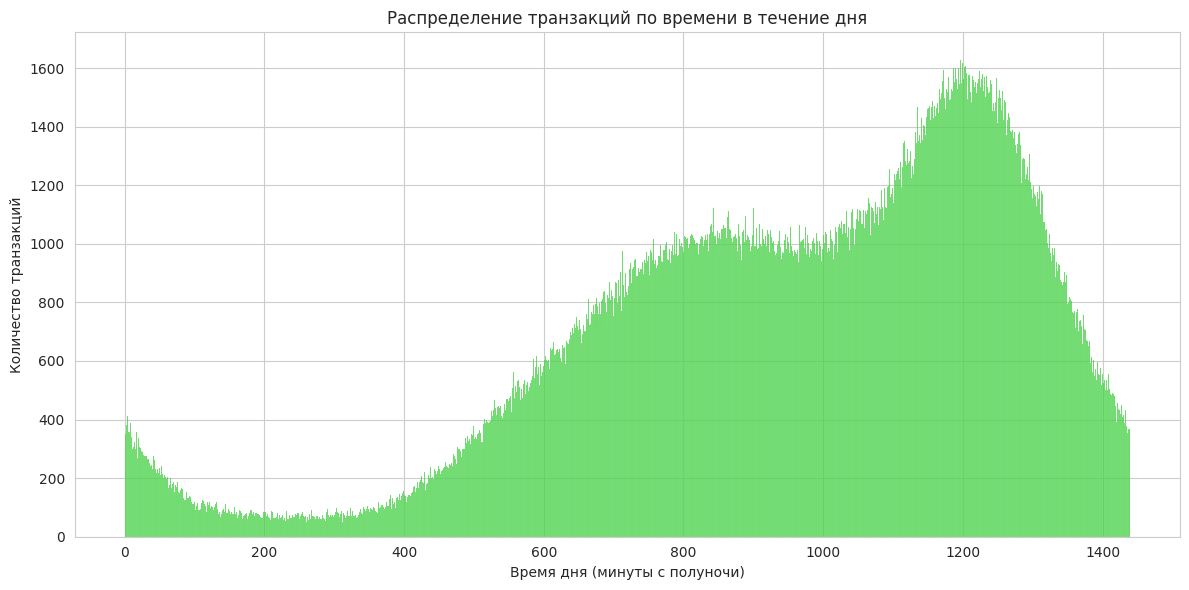

In [ ]:
# Визуализируем распределение времени транзакций в течение дня (в минутах)
plt.figure(figsize=(12, 6))
sns.set_palette("Greens") # Установка зеленой палитры
sns.histplot(df['minuteOfDay'], bins=1440, kde=False, color='limegreen') # 1440 минут в дне
plt.title('Распределение транзакций по времени в течение дня')
plt.xlabel('Время дня (минуты с полуночи)')
plt.ylabel('Количество транзакций')
plt.tight_layout()
plt.show()

- Видно, что количество транзакций ночью (сразу после полуночи) начинает снижаться и держится на низком уровне до примерно 400 минут (около 6:40 утра).
- После этого количество транзакций начинает постепенно расти, достигает первого пика около 840 минут (около 14:00), затем небольшое снижение и повторный подъём, максимальный пик приходится на примерно 1200 минут (около 20:00).
- После максимума количество транзакций быстро падает к полуночи.

## Анализ распределения транзакций по дням недели

Количество транзакций по дням недели:


,dayOfWeek,transactionCount
1,Понедельник,145250
4,Вторник,135691
5,Среда,132463
2,Четверг,141303
6,Пятница,124806
3,Суббота,140020
0,Воскресенье,162732


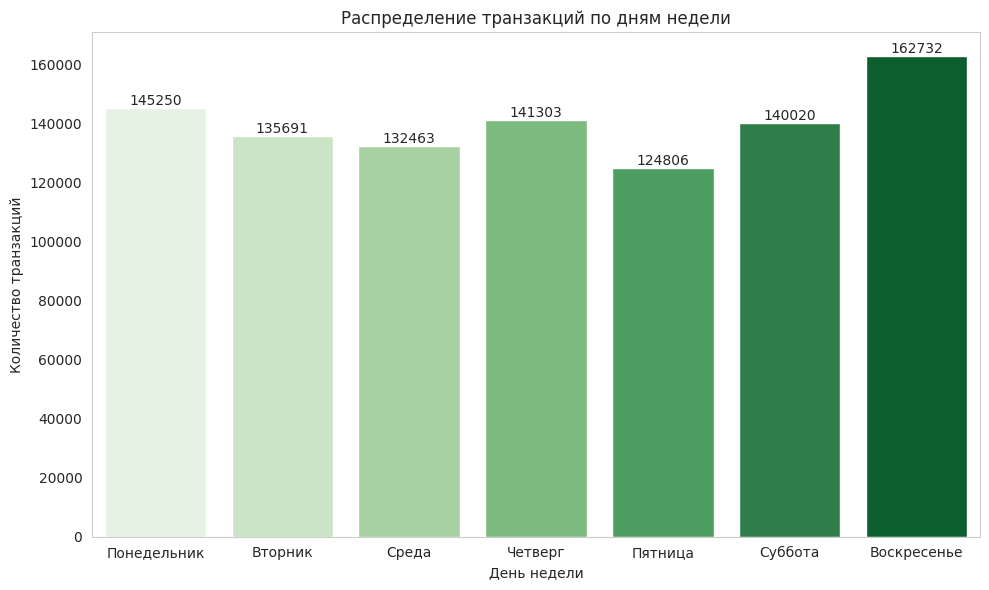

In [ ]:
# Извлекаем день недели из transactionDate
df['dayOfWeek'] = df['transactionDate'].dt.dayofweek

# Переводим номер дня недели в название
days_map = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
df['dayOfWeekName'] = df['dayOfWeek'].map(days_map)

# Считаем количество транзакций по дням недели
transactionsByDay = df['dayOfWeekName'].value_counts().reset_index()
transactionsByDay.columns = ['dayOfWeek', 'transactionCount']

# Сортируем по порядку дней недели
transactionsByDay['dayOfWeek'] = pd.Categorical(transactionsByDay['dayOfWeek'], categories=days_map.values(), ordered=True)
transactionsByDay = transactionsByDay.sort_values('dayOfWeek')

print("Количество транзакций по дням недели:")
display(transactionsByDay)

# Визуализируем количество транзакций по дням недели
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='dayOfWeek', y='transactionCount', data=transactionsByDay, palette='Greens', hue='dayOfWeek', legend=False)
plt.title('Распределение транзакций по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество транзакций')
plt.tight_layout()

# Добавляем подписи со значениями над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Убираем линии сетки
ax.grid(False)

plt.show()

- Видно, что наибольшее количество транзакций приходится на вторник (около 160000).
- Второе по активности — суббота (чуть бьльше 150000) и немного отстают среда и пятница.
- Минимальное количество транзакций наблюдается в четверг (около 120000).

## Динамика суммы транзакций по дате и по месяцам

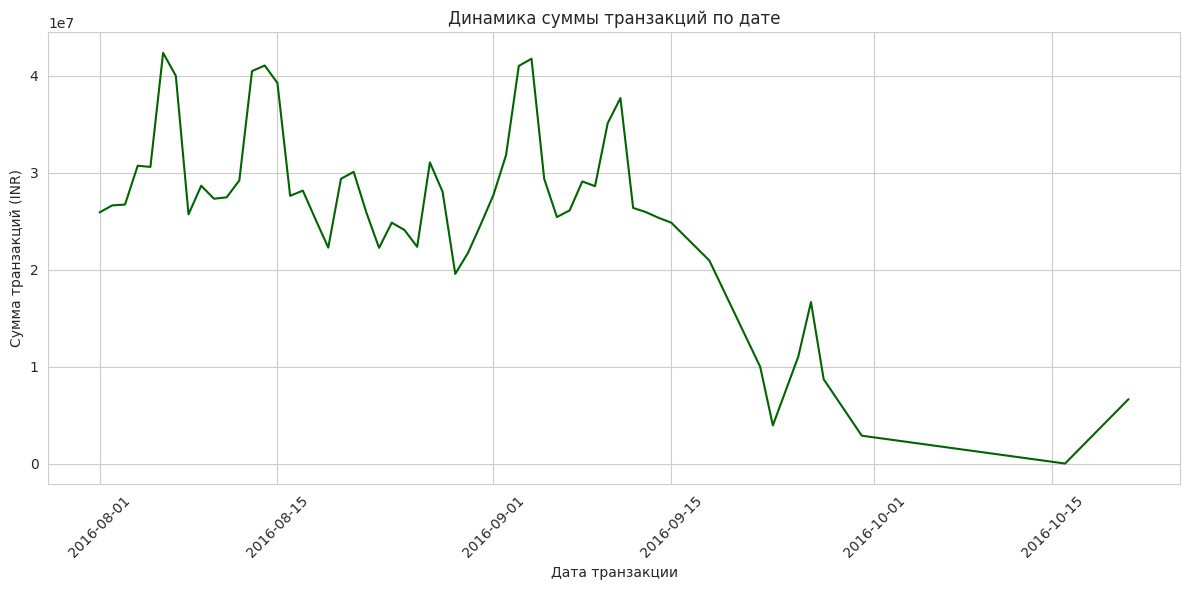

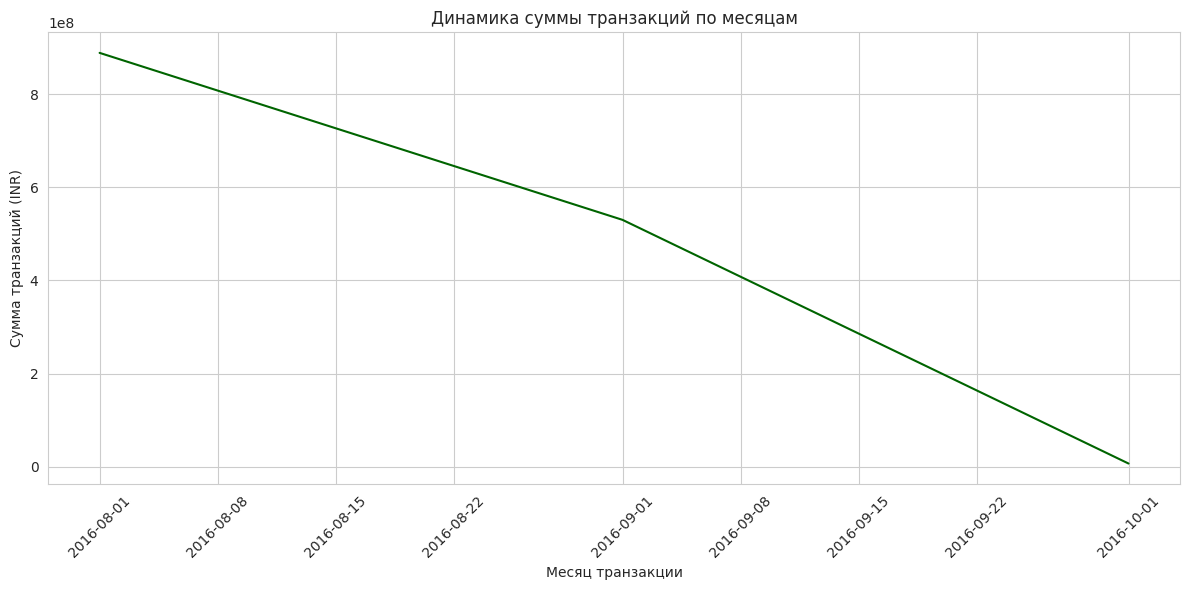

In [ ]:
# Анализ динамики суммы транзакций по дате
dailyTransactionAmount = df.groupby('transactionDate')['transactionAmountInr'].sum().reset_index()
dailyTransactionAmount.columns = ['transactionDate', 'transactionAmount']

# Сортируем по дате для корректного отображения на графике
dailyTransactionAmount = dailyTransactionAmount.sort_values('transactionDate')

# Визуализируем динамику суммы транзакций по дате
plt.figure(figsize=(12, 6))
sns.lineplot(data=dailyTransactionAmount, x='transactionDate', y='transactionAmount', color='darkgreen', linewidth=1.5)
plt.title('Динамика суммы транзакций по дате')
plt.xlabel('Дата транзакции')
plt.ylabel('Сумма транзакций (INR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ динамики суммы транзакций по месяцам
# Извлекаем месяц и год
df['transactionMonth'] = df['transactionDate'].dt.to_period('M')

monthlyTransactionAmount = df.groupby('transactionMonth')['transactionAmountInr'].sum().reset_index()
monthlyTransactionAmount.columns = ['transactionMonth', 'transactionAmount']

# Преобразуем Period в datetime для построения графика
monthlyTransactionAmount['transactionMonth'] = monthlyTransactionAmount['transactionMonth'].dt.to_timestamp()

# Сортируем по месяцу
monthlyTransactionAmount = monthlyTransactionAmount.sort_values('transactionMonth')


# Визуализируем динамику суммы транзакций по месяцам
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthlyTransactionAmount, x='transactionMonth', y='transactionAmount', color='darkgreen', linewidth=1.5)
plt.title('Динамика суммы транзакций по месяцам')
plt.xlabel('Месяц транзакции')
plt.ylabel('Сумма транзакций (INR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На графике динамики суммы транзакций по дате видно ежедневные колебания, а на графике по месяцам - общую тенденцию.

**Закономерности:**
*   **Ежедневные колебания:** Сумма транзакций сильно меняется день ото дня. Это может быть связано с днями недели (например, выходные или будни), днями зарплаты или другими краткосрочными факторами.
*   **Месячная динамика:** Наблюдается снижение общей суммы транзакций к концу периода, представленного в данных (сентябрь-октябрь 2016 года). Это может указывать на сезонность, изменения в клиентской активности или неполноту данных за последние месяцы.

## Распределение среднего баланса по местоположению

Топ 10 местоположений по среднему балансу счета (исключая экстремальные значения):


,custLocationTranslated,custAccountBalance
0,Сан-Хосе,1139138.68
1,Пенджаб,1120613.76
2,Наваншахар,1117171.50
3,Ассоциация Калькутты,1098529.06
4,Рачи,1088480.46
5,Битигхайм,1080483.17
6,Абу-Даби,1079451.46
7,Хардвар,1063218.44
8,Зумари Тилая,1046346.96
9,Доклендс,1044997.24


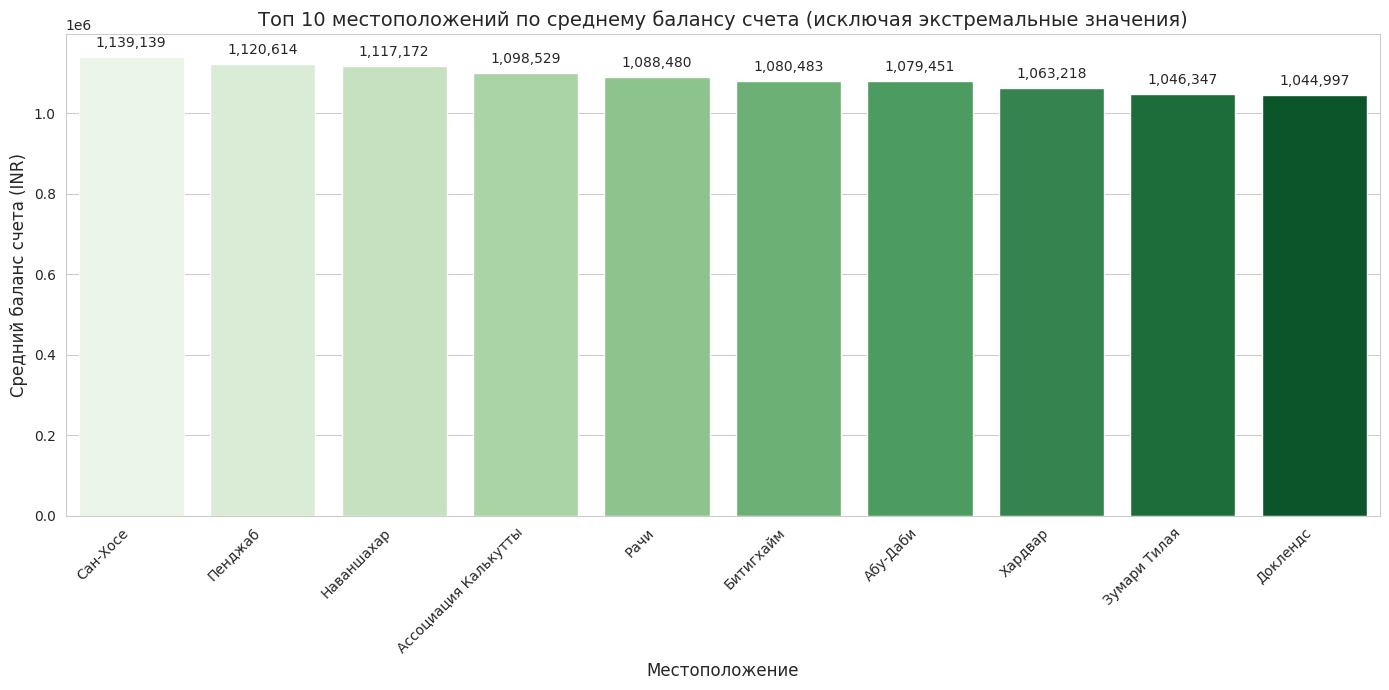

In [ ]:
# Группировка и расчёт среднего баланса по городам
balanceByLocation = (
    df.groupby('custLocation', dropna=False)['custAccountBalance']
    .mean()
    .reset_index()
)

# Убираем экстремальные значения (99-й перцентиль)
balanceCap = balanceByLocation['custAccountBalance'].quantile(0.99)
balanceByLocationFiltered = (
    balanceByLocation[balanceByLocation['custAccountBalance'] <= balanceCap]
    .sort_values('custAccountBalance', ascending=False)
    .reset_index(drop=True)
    .copy()
)

# --- Словарь переводов (все ключи в верхнем регистре, без лишних пробелов) ---
cityTranslation = {
    'PO BOX 28483 DUBAI': 'Почтовый ящик 28483 Дубай',
    'RENTON': 'Рентон',
    'SULTANATE OF OMAN': 'Султанат Оман',
    'SHILLONG': 'Шиллонг',
    'AHMADI': 'Ахмади',
    'SOMAJIGUDA HYDERABAD': 'Сомаджигуда Хайдарабад',
    'SAKAKA': 'Сакака',
    'SPRINGS BANGALORE': 'Спрингс Бангалор',
    'MOMBASA': 'Момбаса',
    'BROOKLYN': 'Бруклин',
    'SOUTH KONANAKE BANGALORE': 'Южный Конанаке Бангалор',
    'BHAJAN PURA DELHI': 'Бхаджан Пура Дели',
    'COLONY GORAKHPUR': 'Колония Горакхпур',
    'NEAR BATA MORE KOLKATA': 'Рядом с Бата Мор Калькутта',
    'WINES CHARLAPALLY HYDERABAD': 'Винный Чарлапалли Хайдарабад',
    'SRIPERUMBUDUR TALUK KANCHEEPURAM': 'Шриперумбудур Талук Канчипурам',
    'SAHEBGANJ': 'Сахебгандж',
    'KOPERKHAIRNE NAVI MUMBAI': 'Коперкхайрне Нави Мумбай',
    'MANGALORE D K': 'Мангалор Д К',
    'BARODA-VADODARA': 'Барода-Вадодара',
    'SAN JOSE': 'Сан-Хосе',
    'PUNJAB': 'Пенджаб',
    'NAWANSHAR': 'Наваншахар',
    'ASSOCIATION KOLKATA': 'Ассоциация Калькутты',
    'RACHI': 'Рачи',
    'BIETIGHEIM': 'Битигхайм',
    'ABU DHABI': 'Абу-Даби',
    'HARDWAR': 'Хардвар',
    'ZUMARI TILAIYA': 'Зумари Тилая',
    'DOCKLANDS': 'Доклендс',
    'DECATHLON SPORTS AHMEDABAD': 'Декатлон Спортс Ахмедабад' # Добавлен перевод для Decathlon Sports Ahmedabad
}

# --- Нормализация локаций перед маппингом ---
def normalize_loc(s):
    if pd.isna(s):
        return s
    return " ".join(str(s).strip().split()).upper()

balanceByLocationFiltered['custLocationNorm'] = balanceByLocationFiltered['custLocation'].apply(normalize_loc)

# --- Применяем переводы ---
balanceByLocationFiltered['custLocationTranslated'] = (
    balanceByLocationFiltered['custLocationNorm']
    .map(cityTranslation)
    .fillna(balanceByLocationFiltered['custLocation'])
)

# --- Топ-10 ---
top10 = balanceByLocationFiltered.head(10).reset_index(drop=True)


print("Топ 10 местоположений по среднему балансу счета (исключая экстремальные значения):")
display(top10[['custLocationTranslated', 'custAccountBalance']])


# --- Визуализация ---
sns.set_style('whitegrid')
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x='custLocationTranslated',
    y='custAccountBalance',
    data=top10,
    palette='Greens'
)

plt.title('Топ 10 местоположений по среднему балансу счета (исключая экстремальные значения)', fontsize=14)
plt.xlabel('Местоположение', fontsize=12)
plt.ylabel('Средний баланс счета (INR)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Подписи над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,.0f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

Самые высокие средние балансы счета наблюдаются в локациях, которые могут быть не самыми крупными городами по количеству транзакций (в отличие от Мумбая или Дели), но где, вероятно, проживают более состоятельные клиенты или происходит больше крупных финансовых операций. Примеры таких локаций из топ-10 списка включают Сан-Хосе, Пенджаб, Наваншахар, Ассоциация Калькутты и Рачи. Эти регионы представляют интерес для банка как потенциальные источники значительных средств.

Фильтрация по 99-му перцентилю среднего баланса позволила исключить аномально высокие значения, которые могли бы исказить картину, и получить более реалистичное представление о типичном высоком уровне баланса в различных локациях.

# Выводы по результатам исследования

В результате исследования данных о банковских транзакциях клиентов были выявлены следующие ключевые закономерности:

1.  **Общие характеристики данных:**
    *   Датасет содержит информацию о более чем 1 миллионе транзакций.
    *   Большинство клиентов совершили по одной транзакции, что указывает на наличие значительной доли "одноразовых" клиентов.

2.  **Финансовое поведение клиентов:**
    *   Распределения баланса счета и суммы транзакций сильно смещены вправо, что говорит о наличии клиентов с очень крупными балансами и редких, но больших по сумме транзакций. Медиана лучше характеризует типичного клиента/транзакцию, чем среднее значение.
    *   Логарифмическое преобразование помогло лучше визуализировать распределение балансов и сумм транзакций, показав, что типичный баланс находится в диапазоне 8-22K INR, а типичная сумма транзакции - 150-1100 INR.

3.  **Демографические характеристики:**
    *   Основная масса клиентов находится в возрасте от 20 до 40 лет, с пиком около 25-30 лет.
    *   Примерно три четверти клиентов – мужчины, четверть – женщины.
    *   Медианный баланс у женщин немного выше, чем у мужчин, но мужчины проявляют большую активность по количеству транзакций.

4.  **Влияние возраста на платежеспособность:**
    *   С увеличением возраста средняя сумма транзакций и медианный баланс счета растут.
    *   Самые "богатые" сегменты клиентов - это группы 45+ лет, особенно 55-64 и 65+.

5.  **Географическое распределение:**
    *   Клиенты представлены в большом количестве населенных пунктов, но большинство транзакций и сумм транзакций сосредоточено в крупных городах Индии, таких как Мумбай, Бангалор и Нью-Дели.
    *   Высокий средний баланс наблюдается не только в крупнейших городах, но и в определенных локациях, где, вероятно, проживают более состоятельные клиенты.

6.  **Временные закономерности:**
    *   Количество транзакций в течение дня достигает пиков днем (около 14:00) и вечером (около 20:00), с резким снижением ночью.
    *   Наблюдается снижение количества и суммы транзакций в последние месяцы исследуемого периода (сентябрь-ноябрь 2016 года), что может быть связано с сезонностью или другими факторами.
    *   Распределение транзакций по дням недели относительно равномерное, с небольшими колебаниями.

# Рекомендации

1. Повышение активности клиентов (1-2 транзакции):
   *  Внедрить программы лояльности и кешбэка за увеличение количества транзакций.
   *  Предлагать персонализированные услуги, стимулирующие расширенное использование функционала (например, автоплатежи, инвестиции).
2. Гендерная стратегия:
   *  Для мужчин (активные): фокусироваться на цифровых, быстрых транзакционных продуктах и удобстве онлайн-сервисов.
   *  Для женщин (высокий баланс): активно продвигать сберегательные, инвестиционные продукты и услуги персонального банкинга.
3. Возрастной фокус:
   *  Для 25-30 лет (наиболее активные): Продолжать развивать передовые цифровые сервисы и предлагать продукты, соответствующие их жизненному этапу (ипотека, образование).
   *  Для других групп: Разработать таргетированные предложения (например, молодежные карты, пенсионные накопления).
4. Географическая стратегия:
   *  Изучить факторы успеха в Мумбаи и реплицировать их в других регионах.
   *  Разработать локализованные маркетинговые кампании и продуктовые предложения для менее активных городов.
5. Оптимизация по времени:
   *  Усилить поддержку клиентов и маркетинговую активность во вторник в 20:00.
   *  Планировать технические работы на время наименьшей активности.
6. **Реакция на тренды:**
   *  Провести глубокий анализ причин снижения активности (например, осень 2016) для предотвращения подобных ситуаций.
   *  Внедрить систему раннего предупреждения для оперативного выявления аномалий.
7. **Сбор данных:**
   *  Улучшить качество сбора данных о дате рождения клиентов, чтобы избежать появления аномалий (например, 1800-01-01).